# Neural Decoding of Motor Signals Using Spiking Neural Networks

In this project, we worked with a dataset of spike trains recorded from the motor cortex of a monkey performing a task that involved moving a pointer on a screen. The goal was to decode the pointer's velocity from the neural data using a network of leaky integrate-and-fire neurons. These networks were designed to take the recorded spike trains as input and output sequences of velocities, with training performed through surrogate gradient descent.

Our approach was inspired by the methodology outlined in the article ["Machine Learning for Neural Decoding" (Glaser et al. 2020)](https://doi.org/10.1523/ENEURO.0506-19.2020). However, we implemented a spiking neural network decoder instead of the statistical and artificial neural network models used in the original study. The dataset and insights from the paper ["Population Coding of Conditional Probability Distributions in Dorsal Premotor Cortex" (Glaser et al. 2018)](https://doi.org/10.1038/s41467-018-04062-6) also informed our work.

The dataset included an array of spike trains (`spike_trains`), where each entry represented the recorded spike times (in seconds) for a neuron. Additionally, the velocity data (`vel`) was provided as a two-dimensional array containing x and y velocity components, along with corresponding timestamps (`vel_times`). This setup enabled us to model and decode the neural representation of motor signals.

## Setting up

In [1]:
!pip install torch torchvision torchaudio numpy scipy matplotlib tqdm

In [3]:
import pickle

import numpy as np
from scipy import io
from scipy.signal import savgol_filter

import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as tnnf
mse = nn.MSELoss()

from tqdm.notebook import tqdm

ms = 1e-3 # use this constant so you can write e.g. 1*ms for a time

In [4]:
import urllib.request, zipfile, os
filename = 's1_data_raw.mat'
if not os.path.exists(filename):
    urllib.request.urlretrieve('https://www.dropbox.com/sh/n4924ipcfjqc0t6/AACPWjxDKPEzQiXKUUFriFkJa?dl=1', 'data.zip')
    with zipfile.ZipFile('data.zip') as z:
        z.extract(filename)

The code below first loads the raw data, which is stored as a Matlab file, and then extracts the three arrays ``spike_times``, ``vel`` and ``vel_times``.

In [5]:
# Load the raw data
data = io.loadmat('s1_data_raw.mat') # a matlab file!
spike_times = [st[:, 0] for st in data['spike_times'].ravel()] # a list of arrays of spike times in seconds, one for each neuron, spike times in seconds
vel = data['vels'] # velocity data shape (num_time_points, 2) for (x, y) coordinates
vel_times = data['vel_times'].squeeze() # times the velocities were recorded

## Data Processing

Preprocessing the data and computing essential statistics to better understand the dataset. 

1. The recorded velocities were whitened by transforming them to have a mean of 0 and a standard deviation of 1, ensuring uniform scaling.  
2. We calculated the number of neurons and the total number of spikes recorded in the dataset.  
3. The duration of the experiment was determined in both seconds and minutes, providing context for the data's timescale.  
4. We estimated the sampling rate of the spike recordings, reflecting how frequently neural activity was captured.  
5. Similarly, we computed the sampling rate of the velocity recordings, which were collected using a different measurement system.  

These steps highlighted the differences in sampling rates between the spike and velocity data, guiding subsequent analyses and ensuring proper synchronization across modalities.

In [10]:
"""
Neural data preprocessing and analysis script.
Performs velocity whitening and computes basic statistics for neural recordings.
"""

# 1. Whiten the recorded velocities (transform to mean = 0, std = 1)
# Compute mean and standard deviation along the time axis (axis=0)
mean = np.mean(vel, axis=0)
std = np.std(vel, axis=0)

# Apply whitening transformation
vel_whitened = (vel - mean) / std
vel = vel_whitened

# Verify whitening was successful
whitened_mean = np.mean(vel_whitened, axis=0)
whitened_std = np.std(vel_whitened, axis=0)

print("Whitened Mean (result is effectively 0 as it is so small):", whitened_mean)
print("Whitened std:", whitened_std)

# 2. Compute basic neural recording statistics
# Count total number of recorded neurons
num_neurons = len(spike_times)

# Calculate total spikes across all neurons
num_spikes = sum(len(times) for times in spike_times)

print(f"Number of neurons: {num_neurons}")
print(f"Total number of spikes: {num_spikes}")

# 3. Compute experiment duration
# Find earliest and latest spike times across all neurons
start_time = min(times[0] for times in spike_times if len(times) > 0) # Earliest spike
end_time = max(times[-1] for times in spike_times if len(times) > 0)  # Latest spike

# Calculate total duration in seconds and minutes
duration_seconds = end_time - start_time
duration_minutes = duration_seconds / 60

print(f"Start Time: {start_time} seconds")
print(f"End Time: {end_time} seconds")
print(f"Duration: {duration_seconds:.2f} seconds ({duration_minutes:.2f} minutes)")

# 4. Compute spike sampling rates
# Calculate overall and per-neuron spike rates
sampling_rate_spikes = num_spikes / duration_seconds
sampling_rate_per_neuron = sampling_rate_spikes / num_neurons

print(f"Sampling Rate for Spikes in total: {sampling_rate_spikes:.2f} Hz")
print(f"Sampling Rate for Spikes Per Neuron: {sampling_rate_per_neuron:.2f} Hz")

# 5. Compute velocity sampling rate
# Count number of velocity measurements
num_velocity_points = len(vel_times)

# Calculate velocity sampling rate
sampling_rate_velocities = num_velocity_points / duration_seconds

print(f"Sampling Rate for Velocities: {sampling_rate_velocities:.2f} Hz")

Whitened Mean (result is effectively 0 as it is so small): [-2.59474361e-18  3.15076009e-18]
Whitened std: [1. 1.]
Number of neurons: 52
Total number of spikes: 1480032
Start Time: 0.0094 seconds
End Time: 3071.3337333333334 seconds
Duration: 3071.32 seconds (51.19 minutes)
Sampling Rate for Spikes in total: 481.89 Hz
Sampling Rate for Spikes Per Neuron: 9.27 Hz
Sampling Rate for Velocities: 99.86 Hz


## Data Visualization

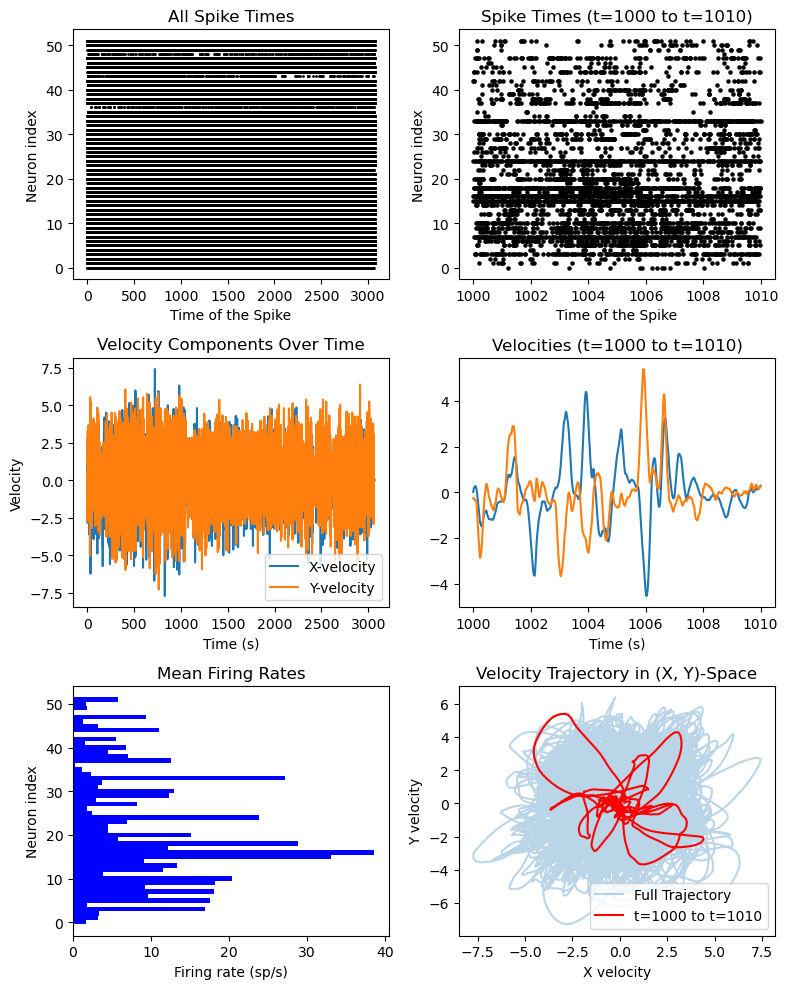

Average firing rate across neurons: 9.27 spikes/s
Maximum firing rate: 38.62 spikes/s
Minimum firing rate: 0.14 spikes/s


In [13]:
"""
This script visualizes the spike times and velocity data in various formats:
1. Raster plots for all spike times and a specific time window (1000 to 1010 seconds).
2. Velocity components (x and y) for the entire dataset and a specific time window.
3. A bar chart showing the mean firing rates of neurons.
4. A 2D trajectory of velocity in (x, y) space, highlighting a specific time window.
"""

plt.figure(figsize=(8, 10))

# Plot 1: All spike times (Raster Plot)
# -------------------------------------
# Each neuron index is plotted against its respective spike times.
ax = plt.subplot(321)
for neuron_idx, times in enumerate(spike_times):
    plt.scatter(times, [neuron_idx] * len(times), s=1, color="black")  
plt.xlabel("Time of the Spike")
plt.ylabel("Neuron Index")
plt.title("All Spike Times")

# Plot 2: Spike times for t=1000 to t=1010
# ----------------------------------------
# Focuses on a specific time window to zoom in on spike details.
ax = plt.subplot(322)
spike_times_window = [times[(times >= 1000) & (times <= 1010)] for times in spike_times]
for neuron_idx, times in enumerate(spike_times_window):
    plt.scatter(times, [neuron_idx] * len(times), s=5, color="black")
plt.xlabel("Time of the Spike")
plt.ylabel("Neuron Index")
plt.title("Spike Times (t=1000 to t=1010)")

# Plot 3: All velocity components (x and y)
# -----------------------------------------
# Velocity over time is shown for both x and y components.
plt.subplot(323)
plt.plot(vel_times, vel[:, 0], label="X-velocity")  # X-velocity curve
plt.plot(vel_times, vel[:, 1], label="Y-velocity")  # Y-velocity curve
plt.xlabel("Time (s)")
plt.ylabel("Velocity")
plt.legend(loc="best")
plt.title("Velocity Components Over Time")

# Plot 4: Velocity components for t=1000 to t=1010
# ------------------------------------------------
# Highlights velocity components in a specific time window.
plt.subplot(324)
indices_window = (vel_times >= 1000) & (vel_times <= 1010)  # Filter indices for the time window
vel_window = vel[indices_window]
vel_times_window = vel_times[indices_window]
plt.plot(vel_times_window, vel_window[:, 0], label="X-velocity")  # X-velocity in window
plt.plot(vel_times_window, vel_window[:, 1], label="Y-velocity")  # Y-velocity in window
plt.xlabel("Time (s)")
plt.title("Velocities (t=1000 to t=1010)")

# Plot 5: Mean firing rate (bar chart)
# ------------------------------------
# Firing rate for each neuron is calculated and displayed as a horizontal bar chart.
plt.subplot(325)
firing_rates = [len(times) / duration_seconds for times in spike_times]
plt.barh(range(len(firing_rates)), firing_rates, height=1, color="blue") 
plt.xlabel("Firing Rate (spikes/s)")
plt.ylabel("Neuron Index")
plt.title("Mean Firing Rates")

# Plot 6: Velocity trajectory in (x, y)-space
# -------------------------------------------
# Plots the trajectory in (x, y) space, emphasizing the specific time window.
plt.subplot(326)
plt.plot(vel[:, 0], vel[:, 1], alpha=0.3, label="Full Trajectory") 
plt.plot(vel_window[:, 0], vel_window[:, 1], color="red", label="t=1000 to t=1010")  
plt.xlabel("X Velocity")
plt.ylabel("Y Velocity")
plt.legend(loc="best")
plt.title("Velocity Trajectory in (X, Y)-Space")

# Adjust layout to avoid overlapping plots
plt.tight_layout()
plt.show()

# Computes and prints the overall, maximum, and minimum firing rates across neurons.
avg_firing_rate = np.mean(firing_rates)
max_firing_rate = np.max(firing_rates)
min_firing_rate = np.min(firing_rates)

print(f"Average firing rate across neurons: {avg_firing_rate:.2f} spikes/s")
print(f"Maximum firing rate: {max_firing_rate:.2f} spikes/s")
print(f"Minimum firing rate: {min_firing_rate:.2f} spikes/s")

## Divide data into test/train and batches

We implemented a generator function, `batched_data`, to iterate over the dataset in randomly ordered segments of specified lengths, returning the data in batches. This function was designed to take parameters such as the range of data, the simulation time step, batch length (in seconds), and batch size. The output consisted of two arrays:  
- `x`: A spike time array of shape `(batch_size, num_neurons, num_time_points)`, where 0 represents no spike and 1 represents a spike.  
- `y`: A velocity array of shape `(batch_size, 2, num_time_points)` corresponding to the x and y components of the velocity at the same time points as the spikes. Velocity values were interpolated to match the time resolution of the spikes.  

To validate the function, we plotted a sample batch showing spike times and velocities for a random batch of 1 second with a batch size of 4. This step confirmed the synchronization of spikes and velocities in the generated batches and provided insights into the data's structure.

In [14]:
def gimme_some_multiples(n):
    yield n*1
    yield n*2
    yield n*3

for x in gimme_some_multiples(3):
    print(x)

3
6
9


And another:

In [15]:
def gimme_some_more_multiples(n, how_many):
    for i in range(how_many):
        yield n*(i+1)

for x in gimme_some_more_multiples(5, 4):
    print(x)

5
10
15
20


In [16]:
# Define proportions for train, validation, and test splits
# ----------------------------------------------------------
# These proportions define how the dataset is divided into three sets.
train_proportion = 0.70
validation_proportion = 0.15
test_proportion = 0.15

# Compute time boundaries for splits
# -----------------------------------
# Ensure no overlap between training, validation, and testing sets.
train_end = start_time + train_proportion * duration_seconds
validation_end = train_end + validation_proportion * duration_seconds

# Split spike_times into train, validation, and test
# ---------------------------------------------------
# Divide the spike times based on computed time boundaries.
train_spike_times = [
    times[(times >= start_time) & (times < train_end)] for times in spike_times
]
validation_spike_times = [
    times[(times >= train_end) & (times < validation_end)] for times in spike_times
]
test_spike_times = [times[(times >= validation_end)] for times in spike_times]

# Split velocity data into train, validation, and test
# -----------------------------------------------------
# Use boolean masks to separate velocity data for each set.
train_indices = (vel_times >= start_time) & (vel_times < train_end)
validation_indices = (vel_times >= train_end) & (vel_times < validation_end)
test_indices = vel_times >= validation_end

train_vel = vel[train_indices]
train_vel_times = vel_times[train_indices]

validation_vel = vel[validation_indices]
validation_vel_times = vel_times[validation_indices]

test_vel = vel[test_indices]
test_vel_times = vel_times[test_indices]

# Summarize the number of spikes and velocity time points in each split.
print("Spike Times:")
print(f"  Training: {sum(len(times) for times in train_spike_times)} spikes")
print(f"  Validation: {sum(len(times) for times in validation_spike_times)} spikes")
print(f"  Testing: {sum(len(times) for times in test_spike_times)} spikes")

print("\nVelocity Data:")
print(f"  Training: {len(train_vel_times)} time points")
print(f"  Validation: {len(validation_vel_times)} time points")
print(f"  Testing: {len(test_vel_times)} time points")

Spike Times:
  Training: 1053483 spikes
  Validation: 213488 spikes
  Testing: 213061 spikes

Velocity Data:
  Training: 214877 time points
  Validation: 46070 time points
  Testing: 45753 time points


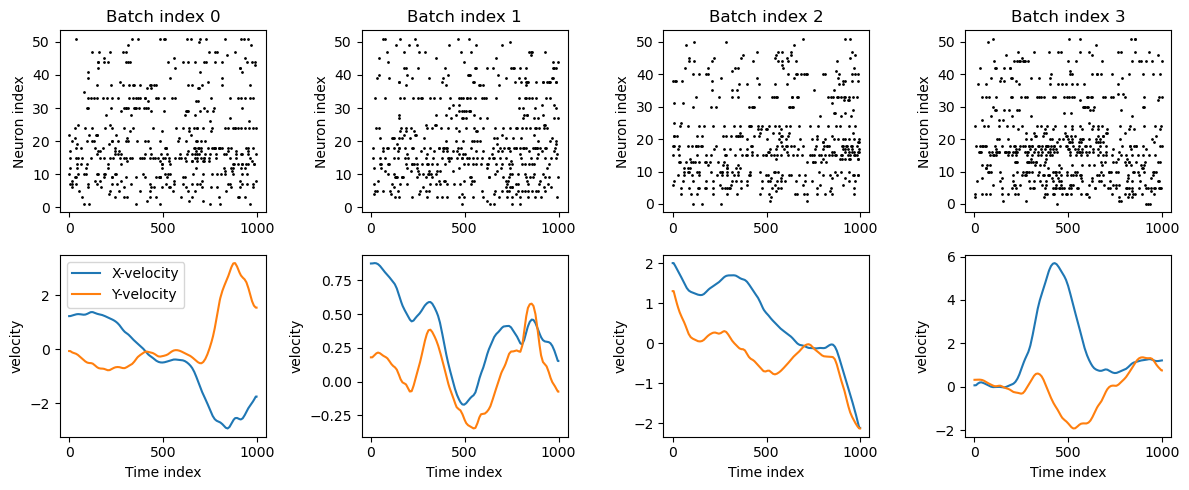

In [21]:
"""
Neural Data Processing and Batch Generation Module

This module implements data organization and batch generation for neural spike train decoding.
It handles the preprocessing of neural spike data and velocity recordings, organizing them into
batches suitable for training neural networks.

The data consists of:
1. Spike trains: Binary events (spikes) from multiple neurons over time
2. Velocity data: Continuous x,y velocity recordings that need to be aligned with spikes

Key Features:
- Splits data into training, validation, and testing sets
- Generates randomized batches of spike-velocity pairs
- Handles temporal alignment between spikes and velocities
- Implements proper interpolation for velocity data
"""

# Set up training, validation, and testing ranges
# ------------------------------------------------
# Organize data into dictionaries for clean access and clear data boundaries.
# This structure ensures no data leakage between sets and makes it easier to
# pass data around to different functions.
train_range = {
    "spike_times": train_spike_times,  # Spike times for training set
    "vel": train_vel,                  # Velocity values for training
    "vel_times": train_vel_times,      # Timestamps for velocity measurements
}
val_range = {
    "spike_times": validation_spike_times,
    "vel": validation_vel,
    "vel_times": validation_vel_times,
}
test_range = {
    "spike_times": test_spike_times,
    "vel": test_vel,
    "vel_times": test_vel_times,
}


def batched_data(range_to_use, dt=1e-3, length=1, batch_size=32):
    """
    Generates batches of time-aligned spike trains and velocity data.
    
    This generator creates training batches by:
    1. Randomly sampling time windows from the full dataset
    2. Converting continuous-time spikes to discrete-time bins
    3. Interpolating velocity data to match spike time resolution
    
    Args:
        range_to_use (dict): Data dictionary containing:
            - spike_times (list): List of arrays with spike times per neuron
            - vel (array): Velocity data array of shape (n_samples, 2)
            - vel_times (array): Timestamps for velocity measurements
        dt (float): Time step for discretization (default: 1ms)
        length (float): Duration of each batch window in seconds
        batch_size (int): Number of samples per batch
    
    Yields:
        tuple: (x, y) where:
            - x (torch.Tensor): Spike data of shape (batch_size, num_neurons, num_time_points)
                              Binary values where 1 indicates a spike
            - y (torch.Tensor): Velocity data of shape (batch_size, 2, num_time_points)
                              Continuous values for x,y velocities
    """
    spike_times = range_to_use["spike_times"]
    vel = range_to_use["vel"]
    vel_times = range_to_use["vel_times"]

    num_neurons = len(spike_times)  # Total number of recorded neurons
    num_time_points = int(length / dt)  # Number of discrete time bins

    # Calculate total available time range for sampling
    total_time = vel_times[-1] - vel_times[0]
    num_batches = int(total_time // length)

    for batch_idx in range(num_batches):
        # Initialize tensors for batch data storage
        # x: spike data as binary events
        # y: continuous velocity values
        x = torch.zeros((batch_size, num_neurons, num_time_points))
        y = torch.zeros((batch_size, 2, num_time_points))

        for b in range(batch_size):
            # Randomly sample a time window to ensure diverse training data
            max_start = total_time - length  # Ensure window fits within data
            start_time = vel_times[0] + np.random.uniform(0, max_start)
            end_time = start_time + length

            # Create uniformly spaced time points for velocity interpolation
            target_times = np.linspace(start_time, end_time, num_time_points)

            # Process spike data: convert continuous time to discrete bins
            for neuron_idx, times in enumerate(spike_times):
                mask = (times >= start_time) & (times < end_time)
                spikes_in_window = times[mask]

                if len(spikes_in_window) > 0:
                    # Convert spike times to indices in the discretized array
                    spike_indices = ((spikes_in_window - start_time) / dt).astype(int)
                    spike_indices = spike_indices[spike_indices < num_time_points]
                    x[b, neuron_idx, spike_indices] = 1.0

            # Process velocity data: interpolate to match spike time resolution
            vel_mask = (vel_times >= start_time) & (vel_times <= end_time)
            vel_time_batch = vel_times[vel_mask]
            vel_batch = vel[vel_mask]

            if len(vel_time_batch) > 0:
                # Interpolate x and y velocities separately
                y[b, 0, :] = torch.tensor(
                    np.interp(target_times, vel_time_batch, vel_batch[:, 0]),
                    dtype=torch.float32,
                )
                y[b, 1, :] = torch.tensor(
                    np.interp(target_times, vel_time_batch, vel_batch[:, 1]),
                    dtype=torch.float32,
                )

        yield x, y


# Visualization of batch samples
# --------------------------------------------
# Generate and plot example batches to verify data processing
x, y = next(batched_data(train_range, dt=1e-3, length=1, batch_size=4))

plt.figure(figsize=(12, 5))

for b in range(4):
    # Top row: Spike raster plots showing binary spike events
    ax = plt.subplot(2, 4, b + 1)
    for neuron_idx in range(x.shape[1]):
        spike_times = np.where(x[b, neuron_idx, :] == 1)[0]
        plt.scatter(spike_times, [neuron_idx] * len(spike_times), s=1, color="black")
    plt.ylabel("Neuron index")
    plt.title(f"Batch index {b}")

    # Bottom row: Corresponding velocity traces
    plt.subplot(2, 4, b + 5, sharex=ax)
    time_indices = np.arange(y.shape[2])
    plt.plot(time_indices, y[b, 0, :].numpy(), label="X-velocity")
    plt.plot(time_indices, y[b, 1, :].numpy(), label="Y-velocity")
    plt.xlabel("Time index")
    plt.ylabel("Velocity")
    if b == 0:
        plt.legend(loc="best")

plt.tight_layout()
plt.show()

## Surrogate Gradient Descent Spike Function

In [17]:
class SurrogateHeaviside(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements
    the surrogate gradient. By subclassing torch.autograd.Function,
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid
    as this was done in Zenke & Ganguli (2018).
    """

    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which
        we need to later backpropagate our error signals. To achieve this we use the
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the
        surrogate gradient of the loss with respect to the input.
        Here we use the normalized negative part of a fast sigmoid
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrogateHeaviside.scale*torch.abs(input)+1.0)**2
        return grad

# here we overwrite our naive spike function by the "SurrogateHeaviside" nonlinearity which implements a surrogate gradient
surrogate_heaviside  = SurrogateHeaviside.apply

## Simulation Code

Modular simulation code was developed to model a layer of leaky integrate-and-fire spiking neurons, ensuring compatibility with PyTorch's autodifferentiation capabilities. The code accepts input batches of spikes (`x`) with shape `(batch_size, num_input_neurons, num_time_points)` and outputs either spiking or non-spiking results, depending on the configuration. Outputs take the form of an array `y` with shape `(batch_size, num_output_neurons, num_time_points)`, where spiking output consists of 0s and 1s, and non-spiking output represents membrane potential values.

The implementation includes initialization of weight matrices and allows the customization of neuron time constants as hyperparameters. For example, a `tau` value of 50 ms was used for spiking neurons and 500 ms for non-spiking neurons, yielding effective results.

The approach followed these steps:  
1. Developed and tested a single-layer, non-spiking neural network for rapid prototyping.  
2. Extended the code to handle spiking neurons and verified output quality before training.  
3. Enabled visualization of spiking hidden layers and fine-tuned the network initialization.  
4. Trained the spiking neural network incrementally, optimizing training curves by experimenting with epoch numbers, batch sizes, and other parameters.  

This structured process ensured both functional and efficient simulations for the spiking neural network model.

## SNN Models

In [ ]:
"""
Spiking Neural Network (SNN) Implementation Module

This module implements various architectures of Spiking Neural Networks (SNNs) for neural decoding.
It provides implementations of:
1. Basic SNN Layer with Leaky Integrate-and-Fire (LIF) neurons
2. Single-layer SNN for direct input-to-output mapping
3. Multi-layer SNN with spiking hidden layer for more complex transformations

Key Features:
- Configurable membrane time constants for temporal integration
- Support for both spiking and non-spiking outputs
- Surrogate gradient learning compatibility
- Flexible architecture configuration
"""
class SNNLayer(nn.Module):
    """
    Implements a single layer of a Leaky Integrate-and-Fire (LIF) Spiking Neural Network.
    
    This layer implements the discrete-time LIF neuron model:
    v(t) = decay * v(t-1) + (1 - decay) * (W * x(t) + b)
    where decay = exp(-dt/tau)
    
    The layer can operate in two modes:
    1. Spiking: Outputs binary spikes using a surrogate gradient
    2. Non-spiking: Outputs continuous membrane potentials
    
    Args:
        n_in (int): Number of input neurons
        n_out (int): Number of output neurons
        tau (float): Membrane time constant (in seconds) - controls integration time
        dt (float): Simulation time step (in seconds) - controls temporal resolution
        spiking (bool): If True, outputs binary spikes; if False, outputs membrane potentials
        weight_scale (float): Standard deviation for weight initialization
    
    Notes:
        - Uses fixed zero bias to reduce parameters
        - Implements reset-by-subtraction for improved gradient flow
        - Precomputes decay factor for efficiency
    """

    def __init__(self, n_in, n_out, tau=0.5, dt=0.001, spiking=True, weight_scale=2):
        super().__init__()

        self.n_in = n_in        # Number of input neurons for dimensionality tracking
        self.n_out = n_out      # Number of output neurons defining layer width
        self.tau = tau          # Membrane time constant: larger values create longer temporal integration
        self.dt = dt            # Time step: smaller values give finer temporal resolution but increase computation
        self.spiking = spiking  # Determines neuron type: spiking (binary output) or non-spiking (continuous output)

        # Initialize learnable weights using random normal distribution
        self.weights = nn.Parameter(torch.randn(n_out, n_in) * weight_scale)
        # Initialize bias to 0 (bias is not trainable in this implementation)
        self.bias = 0

        # Precompute the decay factor for the LIF neuron's membrane potential
        # Based on the differential equation: τ dv/dt = -v + I
        # Discrete approximation: v(t+dt) = decay * v(t) + (1-decay) * I(t)
        self.decay = torch.exp(torch.tensor(-dt / tau))

    def forward(self, x):
        # Extract batch dimensions for tensor operations
        batch_size, num_neurons, num_time_points = x.shape

        # Initialize membrane potential for all neurons in the layer
        # Start at resting potential (0) for each neuron
        v = torch.zeros(batch_size, self.n_out, device=x.device)

        # Store outputs (spikes or potentials) for each timestep
        outputs = []

        # Simulate network dynamics through time
        for t in range(num_time_points):
            # Get input spikes for current timestep across all batches
            i_t = x[:, :, t] 

            # Compute synaptic input current through weight multiplication
            i_syn = torch.matmul(i_t, self.weights.t()) + self.bias

            # Update membrane potential using discrete LIF equation
            v = v * self.decay + i_syn * (1 - self.decay)

            if self.spiking:
                # For spiking neurons: generate spikes using surrogate gradient
                spikes = SurrogateHeaviside.apply(v)
                outputs.append(spikes)

                # Reset membrane potential after spike (reset by subtraction)
                v = v * (1 - spikes)
            else:
                # For non-spiking neurons: output membrane potential directly
                outputs.append(v)

        # Combine outputs across time steps into single tensor
        return torch.stack(outputs, dim=2)
 

class SingleLayerSNN(nn.Module):
    """
    Single-layer Spiking Neural Network for direct neural decoding.
    
    This network directly maps input spike trains to continuous output values using
    a single non-spiking LIF layer. The output is scaled to match the expected
    velocity range.
    
    Architecture:
        Input Spikes -> Non-spiking LIF Layer -> Scaled Output
    
    Args:
        num_input_neurons (int): Number of input neurons (recorded neurons)
        tau_output (float): Membrane time constant for output layer integration
        dt (float): Simulation time step for temporal discretization
    
    Notes:
        - Output scaling factor of 10 is empirically determined
        - Non-spiking output provides smooth velocity predictions
    """

    def __init__(self, num_input_neurons, tau_output=0.5, dt=0.001):
        super().__init__()

        # Create single non-spiking output layer
        self.output_layer = SNNLayer(
            num_input_neurons, 
            2, 
            tau=tau_output, 
            dt=dt, 
            spiking=False   # Non-spiking for continuous output
        )

    def forward(self, x):
        # Scale output by 10 to match typical velocity ranges
        # Scaling factor determined empirically from data statistics
        return self.output_layer(x) * 10


class MultiLayerSNN(nn.Module):
    """
    Multi-layer Spiking Neural Network with spiking hidden layer for neural decoding.
    
    This network implements a two-layer architecture:
    1. Spiking hidden layer for feature extraction
    2. Non-spiking output layer for continuous predictions
    
    The architecture allows for:
    - Nonlinear transformation through spiking activation
    - Temporal integration at multiple timescales
    - Complex feature extraction through hidden layer
    
    Architecture:
        Input Spikes -> Spiking Hidden Layer -> Non-spiking Output Layer
    
    Args:
        num_input_neurons (int, optional): Number of input neurons. Defaults to 52.
        hidden_neurons (int, optional): Number of hidden layer neurons. Defaults to 100.
        tau_hidden (float, optional): Hidden layer membrane time constant. Defaults to 0.05.
        tau_output (float, optional): Output layer membrane time constant. Defaults to 0.5.
        dt (float, optional): Simulation time step. Defaults to 0.001.
    
    Notes:
        - Hidden layer uses faster time constant for rapid feature extraction
        - Output layer uses slower time constant for smooth predictions
        - Default parameters are empirically optimized
    """

    def __init__(
        self,
        num_input_neurons=52,    # Match recording array size
        hidden_neurons=100,      # Larger than input for feature expansion
        tau_hidden=0.05,         # Fast time constant for feature detection
        tau_output=0.5,          # Slow time constant for smooth output
        dt=0.001,
    ):
        super().__init__()

        # Hidden layer: spiking neurons for feature extraction
        self.hidden_layer = SNNLayer(
            num_input_neurons, 
            hidden_neurons, 
            tau=tau_hidden, 
            dt=dt, 
            spiking=True
        )

        # Output layer: non-spiking for continuous velocity prediction
        self.output_layer = SNNLayer(
            hidden_neurons, 2, tau=tau_output, dt=dt, spiking=False
        )

    def forward(self, x):
        # Convert input spikes to feature representation
        hidden_spikes = self.hidden_layer(x)

        # No explicit scaling needed due to learned weights
        output = self.output_layer(hidden_spikes)

        return output

## Main Training Loop/Algorithm

In [ ]:
def weighted_mse_loss(pred, target, weight_decay=0.1):
    """
    Custom loss function that applies a temporal weighting to later time steps
    and incorporates L2 regularization for the model parameters.

    Args:
        pred (torch.Tensor): Predicted output of the model with shape 
                             (batch_size, output_features, time_steps).
        target (torch.Tensor): Ground truth values with the same shape as `pred`.
        weight_decay (float, optional): Regularization factor for L2 regularization. Defaults to 0.1.

    Returns:
        torch.Tensor: Weighted Mean Squared Error (MSE) with L2 regularization.
    
    Approach:
        1. Temporal weighting:
           - Applies exponentially increasing weights to time steps, emphasizing later steps more heavily.
        2. Mean Squared Error:
           - Computes the squared difference between predictions and targets, averaged across features.
        3. L2 Regularization:
           - Adds a regularization term to penalize large weights, encouraging simpler models.
        4. Combines weighted MSE and L2 regularization to produce the final loss.
    """
    # Number of time steps in the predictions
    time_steps = pred.size(-1)

    # Generate temporal weights, scaled to sum to approximately 1
    weights = torch.exp(torch.linspace(0, 1, time_steps)) / torch.exp(torch.tensor(1.0))
    weights = weights.to(pred.device) 

    # Compute mean squared error (MSE) across features
    mse = torch.mean((pred - target) ** 2, dim=1)  

    # Apply temporal weighting to the MSE
    weighted_mse = torch.mean(mse * weights)

    # Compute L2 regularization term
    l2_reg = (
        sum(p.pow(2.0).sum() for p in pred.parameters())
        if hasattr(pred, "parameters")
        else 0
    )

    # Return the combined loss: weighted MSE + regularization
    return weighted_mse + weight_decay * l2_reg


def train_network(
    net, train_range, val_range, num_epochs, learning_rate, max_batches_per_epoch
):
    """
    Training function for a SNN, incorporating gradient clipping and a OneCycleLR scheduler techniques.

    Args:
        net (torch.nn.Module): The neural network to train.
        train_range (dict): Training data range containing spike_times, vel, and vel_times.
        val_range (dict): Validation data range containing spike_times, vel, and vel_times.
        num_epochs (int): Number of epochs for training.
        learning_rate (float): Maximum learning rate for the optimizer.
        max_batches_per_epoch (int): Maximum number of batches per epoch.

    Returns:
        dict: A dictionary containing training and validation loss metrics:
              - 'train_loss': List of training loss values for all batches.
              - 'val_loss': List of validation loss values for all batches.
              - 'epoch_train_loss': List of average training losses per epoch.
              - 'epoch_val_loss': List of average validation losses per epoch.

    Approach:
        1. Loss Function:
           - Uses `weighted_mse_loss` for temporal weighting and L2 regularization.
        2. Optimizer and Scheduler:
           - AdamW optimizer is combined with a OneCycleLR scheduler to adjust learning rates dynamically.
        3. Gradient Clipping:
           - Limits the gradient norms to stabilize training and prevent exploding gradients.
        4. Epoch Loop:
           - Alternates between training and validation phases for each epoch.
        5. Metrics Tracking:
           - Tracks and logs the training and validation losses for analysis.
    """
    # Initialize the optimizer with weight decay for regularization
    optimizer = torch.optim.AdamW(
        net.parameters(), lr=learning_rate, weight_decay=0.01
    )

    # OneCycleLR dynamically adjusts the learning rate over the course of training
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=learning_rate,
        epochs=num_epochs,
        steps_per_epoch=max_batches_per_epoch,
    )

    # Define the loss function
    criterion = weighted_mse_loss

    # Initialize metrics for tracking losses
    metrics = {
        "train_loss": [],       # Loss for each batch in the training phase
        "val_loss": [],         # Loss for each batch in the validation phase
        "epoch_train_loss": [], # Average training loss per epoch
        "epoch_val_loss": [],   # Average validation loss per epoch
    }

    print("\nTraining Start:")
    print("Epoch\tTrain Loss\tVal Loss\tLearning Rate")
    print("-" * 50)

    # Main training loop
    with tqdm(total=num_epochs) as pbar:
        for epoch in range(num_epochs):
            # Enable training mode - activates dropout, batch norm updates, etc.
            net.train()
            epoch_train_losses = []  # Store losses for this epoch for averaging later

            # Initialize data generator for training
            train_gen = batched_data(train_range, dt=1e-3, length=1, batch_size=32)

            # Process mini-batches for current epoch
            for batch_idx in range(max_batches_per_epoch):
                try:
                    # Get next batch of spike trains (x) and target velocities (y)
                    x, y = next(train_gen)

                    # Clear accumulated gradients from previous batch
                    optimizer.zero_grad()

                    # Forward propagation: compute network predictions
                    y_pred = net(x)

                    # Calculate loss between predictions and targets
                    loss = criterion(y_pred, y)

                    # Compute gradients through backpropagation
                    loss.backward()

                    # Prevent exploding gradients by clipping norm to 0.5
                    torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=0.5)

                    # Update network parameters using computed gradients
                    optimizer.step()

                    # Update learning rate according to OneCycleLR schedule
                    scheduler.step()

                    # Store loss value for epoch statistics
                    epoch_train_losses.append(loss.item())

                except StopIteration:
                    break

            # Validation Phase: evaluate model performance on unseen data
            net.eval()       # Disable training-specific layers (dropout, batch norm)
            val_losses = []  # Store validation losses

            # Disable gradient computation for validation
            with torch.no_grad():
                # Create validation data generator with larger batch size
                val_gen = batched_data(val_range, dt=1e-3, length=1, batch_size=96)
                
                # Validate on same number of batches as training
                for _ in range(max_batches_per_epoch):
                    try:
                        x, y = next(val_gen)
                        # Compute validation loss without gradient tracking
                        val_loss = criterion(net(x), y)
                        val_losses.append(val_loss.item())
                    except StopIteration:
                        break

            # Calculate average losses for this epoch
            avg_train_loss = np.mean(epoch_train_losses)
            avg_val_loss = np.mean(val_losses)

            # Store metrics for later analysis and plotting
            metrics["epoch_train_loss"].append(avg_train_loss)
            metrics["epoch_val_loss"].append(avg_val_loss)
            metrics["train_loss"].extend(epoch_train_losses)

            # Shows training progress and key metrics in real-time
            pbar.update(1)
            pbar.set_postfix(
                {
                    "train_loss": f"{avg_train_loss:.4f}",
                    "val_loss": f"{avg_val_loss:.4f}",
                    "lr": f"{scheduler.get_last_lr()[0]:.6f}",  # Current learning rate
                }
            )

        # Return collected metrics for analysis and plotting
        return metrics

def evaluate_network(net, data_range, max_batches=None):
    """
    Evaluates a neural network on a given dataset and compares its performance to a null model.

    Args:
        net (torch.nn.Module): The trained neural network to evaluate.
        data_range (dict): The dataset range containing `spike_times`, `vel`, and `vel_times`.
        max_batches (int, optional): The maximum number of batches to evaluate. Defaults to 10 if not provided.

    Returns:
        tuple: A tuple containing:
            - mean_loss (float): The average mean squared error (MSE) loss of the network on the dataset.
            - mean_null_loss (float): The average MSE loss of the null model (predicting all zeros).

    Approach:
        1. Mode Setting: Sets the network to evaluation mode (`net.eval()`) to disable dropout or batch normalization.
        2. Loss Function: Uses PyTorch's `nn.MSELoss` to compute the mean squared error between predictions and targets.
        3. Data Generator: Creates a generator to yield batches of data from `data_range` using `batched_data`.
        4. Null Model: Computes the loss of a trivial model that predicts zeros, serving as a baseline for comparison.
        5. Loss Tracking: Iterates over a fixed number of batches or until the generator is exhausted, tracking:
            - The network's performance (`losses`).
            - The null model's performance (`null_losses`).
        6. Final Metrics: Computes the mean of the tracked losses for both the network and the null model.

    Implementation Notes:
        - The null model provides a reference point; the network should ideally outperform it.
        - The use of `torch.no_grad()` ensures no gradients are computed, improving efficiency during evaluation.
    """
    # Set the network to evaluation mode
    net.eval()

    # Define the loss function (Mean Squared Error)
    criterion = nn.MSELoss()

    # Initialize lists to store losses for the network and null model
    losses = []
    null_losses = []

    # Create a generator to yield batches of data
    gen = batched_data(data_range, dt=1e-3, length=1, batch_size=96)

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for batch_idx in range(max_batches if max_batches else 10):  # Limit to max_batches or 10 batches
            try:
                # Fetch a batch of data
                x, y = next(gen)

                # Forward pass through the network to get predictions
                y_pred = net(x)

                # Compute the MSE loss between predictions and ground truth
                loss = criterion(y_pred, y)
                losses.append(loss.item())  # Append the loss for this batch

                # Compute the null model loss (predicting zeros)
                null_loss = criterion(torch.zeros_like(y), y)
                null_losses.append(null_loss.item())  # Append the null model loss
            except StopIteration:
                break

    # Compute the mean loss for the network and the null model
    mean_loss = np.mean(losses) if losses else float("nan")  # Avoid division by zero if no losses
    mean_null_loss = np.mean(null_losses) if null_losses else float("nan")

    # Return the average losses
    return mean_loss, mean_null_loss

## Experiment Visualizations

In [ ]:
def visualize_predictions(net, data_range, num_samples=4):
    """
    Visualizes the predicted and true velocities for a given dataset.

    Args:
        net (torch.nn.Module): Trained neural network to generate predictions.
        data_range (dict): Data range containing `spike_times`, `vel`, and `vel_times`.
        num_samples (int): Number of samples to visualize. Defaults to 4.

    Approach:
        1. Generate a batch of data using the `batched_data` generator.
        2. Use the trained network to predict velocities from the input spikes.
        3. Compare the predicted and true velocities (x and y) over time.
        4. Plot both true and predicted velocities for each sample in the batch.
        5. Handle cases where there isn’t enough data for visualization.
    """
    plt.figure(figsize=(15, 3 * num_samples))

    # Create a generator and fetch the next batch
    gen = batched_data(data_range, dt=1e-3, length=1, batch_size=num_samples)
    x, y = next(gen)

    with torch.no_grad():
        # Generate predictions using the network
        y_pred = net(x)

        for i in range(min(num_samples, y.shape[0])):
            plt.subplot(num_samples, 1, i + 1)

            # Plot time steps
            time_steps = np.arange(y.shape[-1])

            # Plot true and predicted x-velocity
            plt.plot(
                time_steps,
                y[i, 0, :].cpu().numpy(),
                "b--",
                label="True X-velocity",
                alpha=0.7,
            )
            plt.plot(
                time_steps,
                y_pred[i, 0, :].cpu().numpy(),
                "b-",
                label="Predicted X-velocity",
            )

            # Plot true and predicted y-velocity
            plt.plot(
                time_steps,
                y[i, 1, :].cpu().numpy(),
                "r--",
                label="True Y-velocity",
                alpha=0.7,
            )
            plt.plot(
                time_steps,
                y_pred[i, 1, :].cpu().numpy(),
                "r-",
                label="Predicted Y-velocity",
            )

            plt.title(f"Sample {i + 1}")
            plt.xlabel("Time step")
            plt.ylabel("Velocity")
            if i == 0:
                plt.legend()

    plt.tight_layout()
    plt.show()


def plot_training_history(history):
    """
    Plots training and validation loss curves from the training history.

    Args:
        history (dict): Dictionary containing loss histories with keys:
            - 'train_loss': List of training losses for each batch.
            - 'epoch_train_loss': List of average training losses per epoch.
            - 'epoch_val_loss': List of validation losses per epoch.

    Approach:
        1. Plot the batch-wise training loss to understand intra-epoch variability.
        2. Plot epoch-wise training and validation losses to assess overall performance trends.
        3. Use separate subplots for batch-wise and epoch-wise losses.

    Implementation Notes:
        - The first subplot visualizes batch-level loss fluctuations during training.
        - The second subplot compares training and validation losses per epoch.
        - Helps diagnose overfitting or underfitting during training.
    """
    plt.figure(figsize=(15, 5))

    # Plot batch-wise training loss
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Training Loss", alpha=0.5)
    plt.title("Batch-wise Training Loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot epoch-wise training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(
        history["epoch_train_loss"],
        "b-",
        label="Training Loss",
        linewidth=2,
    )
    plt.plot(
        history["epoch_val_loss"],
        "r-",
        label="Validation Loss",
        linewidth=2,
    )
    plt.title("Epoch-wise Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

## Evaluation Functions

Evaluation functions were implemented to assess network performance and analyze its internal behavior. The primary function calculates the mean loss over the testing data, where the loss is defined as the mean squared error between the network's output and the target data. To establish a baseline, the null loss, representing the loss from outputting all zeros, was also computed.

Additional evaluation included visualizing internal network outputs, such as spikes produced by hidden layers, and analyzing neuron firing rates. A network with one hidden layer of 100 spiking neurons and one output layer of 2 non-spiking neurons was initialized. The evaluation process involved running this network on a random data sample of length 1 and generating the following visualizations:
- Input spikes,
- Hidden layer spikes,
- Output x- and y-velocities compared to target data,
- Firing rate histograms for each spiking neuron in the hidden layer.

The initialization aimed to achieve hidden layer firing rates in the range of 20-100 spikes per second and ensure output values aligned with the target data range. Different weight initialization strategies were tested to avoid uniform neuron behavior, which could hinder learning. The evaluation also included printing the untrained network’s loss and null loss as a baseline.

For efficiency, evaluation code was executed within a `with torch.no_grad()` block to prevent gradient computation during testing. This setup facilitated effective debugging, performance assessment, and network initialization.


Firing Rate Statistics:
Mean firing rate(within target range 20-100Hz): 83.88 Hz
Std firing rate: 72.55 Hz


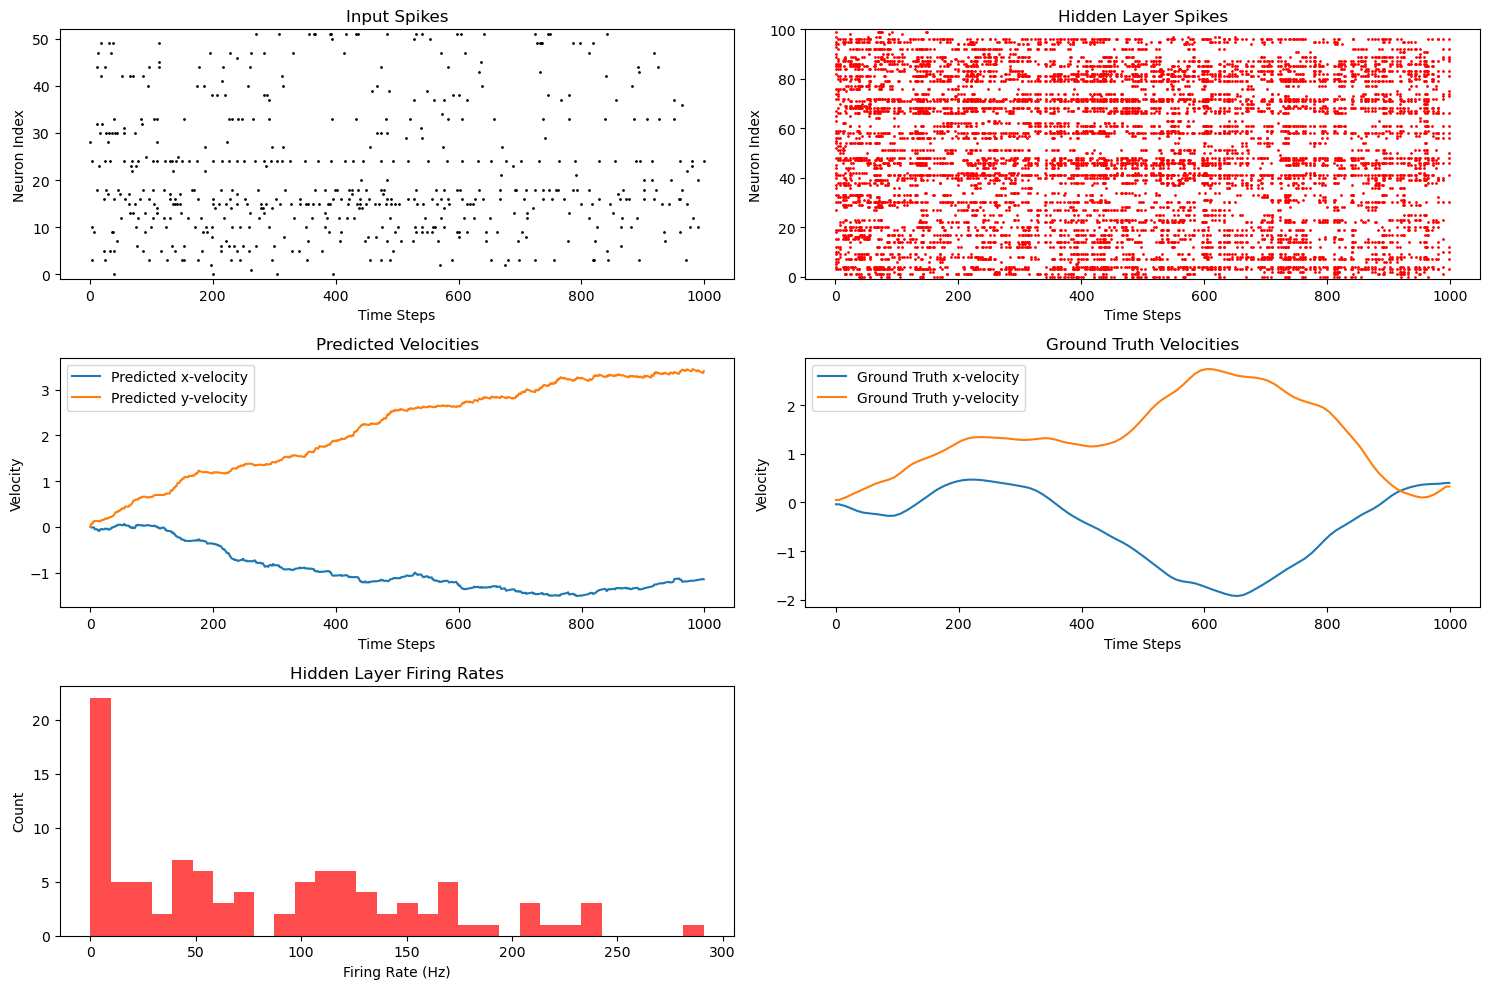


Loss Analysis:
Model Loss: 2.0610
Null Loss: 1.0723


In [55]:
def analyze_network(model, x, y):
    """
    Analyze the activity of a neural network and visualize its behavior.

    Args:
        model (torch.nn.Module): The neural network to analyze.
        x (torch.Tensor): Input spike data of shape (batch_size, num_neurons, num_time_points).
        y (torch.Tensor): Ground truth output data of shape (batch_size, 2, num_time_points).

    Returns:
        tuple:
            - firing_rates (torch.Tensor): Firing rates of hidden layer neurons.
            - y_pred (torch.Tensor): Predicted output velocities.

    Approach:
        1. Compute the predicted outputs (`y_pred`) from the model.
        2. Visualize:
           - Input spike raster plots.
           - Hidden layer spikes.
           - Predicted and ground truth velocities.
           - Histogram of hidden layer firing rates.
        3. Calculate and print firing rate statistics (mean and standard deviation).
    """
    # Get network outputs (predicted velocities)
    y_pred = model(x)

    # Create plots for network analysis
    plt.figure(figsize=(15, 10))

    # 1. Plot input spikes as a raster plot
    plt.subplot(3, 2, 1)
    spike_times = np.where(x[0].numpy() == 1)  # Indices of spikes in the input tensor
    plt.scatter(spike_times[1], spike_times[0], color="black", s=1)
    plt.title("Input Spikes")
    plt.ylabel("Neuron Index")
    plt.xlabel("Time Steps")
    plt.ylim(-1, x.shape[1])

    # 2. Plot hidden layer spikes using the model's hidden layer
    def get_hidden_activations(x):
        """Helper function to extract hidden layer activations."""
        return model.hidden_layer(x)

    hidden_spikes = get_hidden_activations(x)
    plt.subplot(3, 2, 2)
    spike_times = np.where(hidden_spikes[0].detach().numpy() > 0.5)  # Hidden spikes
    plt.scatter(spike_times[1], spike_times[0], color="red", s=1)
    plt.title("Hidden Layer Spikes")
    plt.ylabel("Neuron Index")
    plt.xlabel("Time Steps")
    plt.ylim(-1, hidden_spikes.shape[1])

    # 3. Plot predicted velocities (x and y components)
    plt.subplot(3, 2, 3)
    plt.plot(
        y_pred[0, 0, :].detach().numpy(), label="Predicted x-velocity"
    )
    plt.plot(
        y_pred[0, 1, :].detach().numpy(), label="Predicted y-velocity"
    )
    plt.legend()
    plt.title("Predicted Velocities")
    plt.xlabel("Time Steps")
    plt.ylabel("Velocity")

    # 4. Plot ground truth velocities (x and y components)
    plt.subplot(3, 2, 4)
    plt.plot(y[0, 0, :].numpy(), label="Ground Truth x-velocity")
    plt.plot(y[0, 1, :].numpy(), label="Ground Truth y-velocity")
    plt.legend()
    plt.title("Ground Truth Velocities")
    plt.xlabel("Time Steps")
    plt.ylabel("Velocity")

    # 5. Calculate and plot firing rates as a histogram
    time_window = x.shape[2] * 0.001  # Total time in seconds (assuming dt=1ms)
    firing_rates = torch.sum(hidden_spikes[0].detach(), dim=1) / time_window

    plt.subplot(3, 2, 5)
    plt.hist(firing_rates.numpy(), bins=30, color="red", alpha=0.7)
    plt.title("Hidden Layer Firing Rates")
    plt.xlabel("Firing Rate (Hz)")
    plt.ylabel("Count")

    # Print firing rate statistics
    mean_rate = torch.mean(firing_rates)
    std_rate = torch.std(firing_rates)
    print(f"\nFiring Rate Statistics:")
    print(f"Mean firing rate: {mean_rate:.2f} Hz")
    print(f"Std firing rate: {std_rate:.2f} Hz")

    plt.tight_layout()
    plt.show()

    return firing_rates, y_pred


# Test the network with a sample batch
test_generator = batched_data(test_range, dt=0.001, length=1.0, batch_size=4)
x, y = next(test_generator)

# Initialize the model with appropriate input size
model = MultiLayerSNN(num_input_neurons=52)

# Analyze the network's performance and behavior
firing_rates, y_pred = analyze_network(model, x, y)

# Calculate the loss between predictions and ground truth
criterion = nn.MSELoss()
loss = criterion(y_pred, y)

# Compute the loss of a null model (predicting zeros)
null_loss = criterion(torch.zeros_like(y), y)

print(f"\nLoss Analysis:")
print(f"Model Loss: {loss.item():.4f}")
print(f"Null Loss: {null_loss.item():.4f}")


Layer Initialization Analysis:
------------------------------

Hidden Layer (Spiking):
Average Firing Rate: 81.75 Hz
Maximum Firing Rate: 0.29
% Active Neurons: 99.0%

Output Layer (Non-spiking):
Mean Potential: 0.8155
Std Potential: 0.5006
Range: [-0.0972, 1.8953]


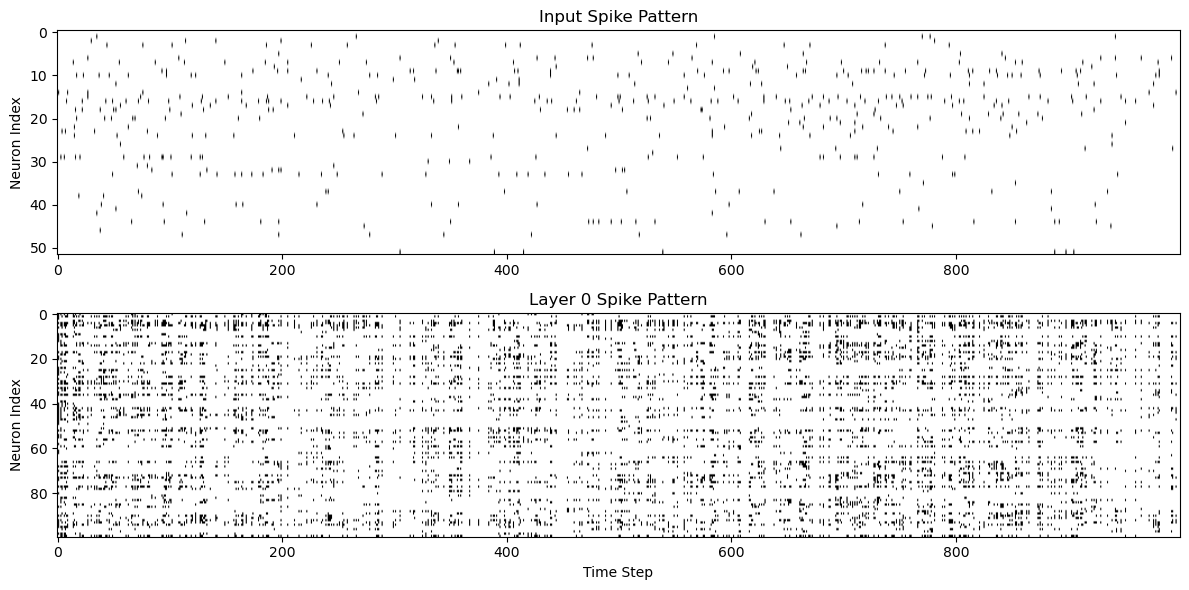

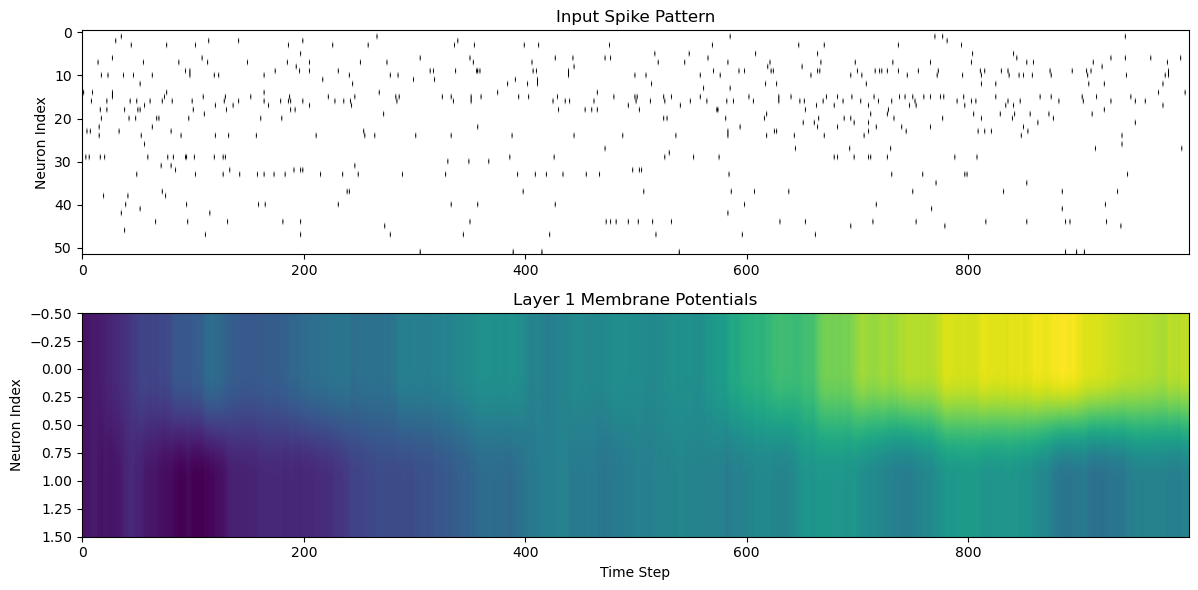

In [43]:
def plot_spike_patterns(net, sample_input, layer_idx=0):
    """
    Visualizes spike patterns or membrane potentials in a specific layer of the network.

    Args:
        net (torch.nn.Module): The neural network to analyze.
        sample_input (torch.Tensor): Input spike pattern of shape (batch_size, num_neurons, num_time_points).
        layer_idx (int): Index of the layer to visualize (0 for hidden layer, 1 for output layer).

    Approach:
        1. Compute the output of the specified layer using the input sample.
        2. Plot:
           - Input spike patterns as a heatmap.
           - Layer output as either a spike heatmap (if spiking) or membrane potential heatmap (if non-spiking).
        3. Use different color maps for spiking (binary) and non-spiking (continuous) layers.
    """
    with torch.no_grad():
        # Compute the output of the specified layer
        if layer_idx == 0:
            # Hidden layer output
            x = net.hidden_layer(sample_input)
            layer = net.hidden_layer
        else:
            # Output layer output
            x = net.output_layer(net.hidden_layer(sample_input))
            layer = net.output_layer

        plt.figure(figsize=(12, 6))

        # Plot input spike pattern
        plt.subplot(2, 1, 1)
        plt.imshow(sample_input[0].cpu().numpy(), aspect="auto", cmap="binary")
        plt.title("Input Spike Pattern")
        plt.ylabel("Neuron Index")

        # Plot layer output (spike pattern or membrane potential)
        plt.subplot(2, 1, 2)
        if layer.spiking:
            # For spiking layers, use binary heatmap
            plt.imshow(x[0].cpu().numpy(), aspect="auto", cmap="binary")
            plt.title(f"Layer {layer_idx} Spike Pattern")
        else:
            # For non-spiking layers, use continuous color map
            plt.imshow(x[0].cpu().numpy(), aspect="auto", cmap="viridis")
            plt.title(f"Layer {layer_idx} Membrane Potentials")
        plt.xlabel("Time Step")
        plt.ylabel("Neuron Index")

        plt.tight_layout()
        plt.show()

def analyze_layer_initialization(net, sample_input, print_stats=True):
    """
    Analyzes the initialization of each layer in the network by examining firing rates 
    (for spiking layers) and membrane potentials (for non-spiking layers).

    Args:
        net (torch.nn.Module): The neural network to analyze.
        sample_input (torch.Tensor): Input spike pattern of shape (batch_size, num_neurons, num_time_points).

    Approach:
        1. Analyze the hidden layer (spiking):
           - Compute average and maximum firing rates.
           - Determine the percentage of active neurons.
        2. Analyze the output layer (non-spiking):
           - Compute mean, standard deviation, and range of membrane potentials.
    """
    with torch.no_grad():
        if print_stats:
            print("\nLayer Initialization Analysis:")
            print("-" * 30)

        # Analyze hidden layer (spiking)
        hidden_output = net.hidden_layer(sample_input)
        spikes = hidden_output.cpu().numpy() 
        firing_rate = np.mean(spikes) * 1000  # Convert to Hz assuming dt=1ms

        if print_stats:
            print(f"\nHidden Layer (Spiking):")
            print(f"Average Firing Rate: {firing_rate:.2f} Hz")
            print(
                f"Maximum Firing Rate: {np.max(np.mean(spikes, axis=2)):.2f} Hz"
            )  # Max firing rate
            print(
                f"% Active Neurons: {100 * np.mean(np.any(spikes > 0, axis=2)):.1f}%"
            )  # Percentage of active neurons

        # Analyze output layer (non-spiking)
        output = net.output_layer(hidden_output)
        potentials = output.cpu().numpy()

        if print_stats:
            print(f"\nOutput Layer (Non-spiking):")
            print(f"Mean Potential: {np.mean(potentials):.4f}")
            print(f"Std Potential: {np.std(potentials):.4f}")
            print(f"Range: [{np.min(potentials):.4f}, {np.max(potentials):.4f}]")

# Test initialization and visualization
sample_batch = next(batched_data(train_range, dt=1e-3, length=1, batch_size=1))
x_sample, _ = sample_batch

model = MultiLayerSNN(num_input_neurons=52)

# Analyze initialization
analyze_layer_initialization(model, x_sample)

# Plot spike patterns for each layer
plot_spike_patterns(model, x_sample, layer_idx=0)  # Hidden layer
plot_spike_patterns(model, x_sample, layer_idx=1)  # Output layer

## Training

We began training by initializing a network with a single non-spiking output layer. This configuration connected input spikes directly to two non-spiking leaky integrate-and-fire (LIF) neurons via a weight matrix. A suitable initialization was identified to ensure the network's outputs were within a reasonable range relative to the target data.

After initialization, an optimization algorithm and learning rate were selected to train the network. The goal was to achieve a loss lower than the null loss, which represents the error when predicting all zeros. Training results showed a typical null loss of approximately 0.8 and a trained loss around 0.6, indicating successful optimization.

To evaluate performance:
- Loss curves for training and validation/test data were plotted to assess convergence.
- The final testing loss was printed to benchmark results.
- Model outputs were compared to target data across 8 randomly sampled 1-second time windows. The comparison revealed that the network often matched the data better in the latter half of the windows, likely due to the network's outputs starting at zero, irrespective of the input's initial state.

This stage provided a baseline for network performance, with a mean squared error approximately 75% of the null MSE, meeting expectations for this phase. While preliminary fits might not have been perfect, they demonstrated the network's ability to capture essential patterns in the data.

In [56]:
# Initialize network
single_layer_net = SingleLayerSNN(num_input_neurons=52)

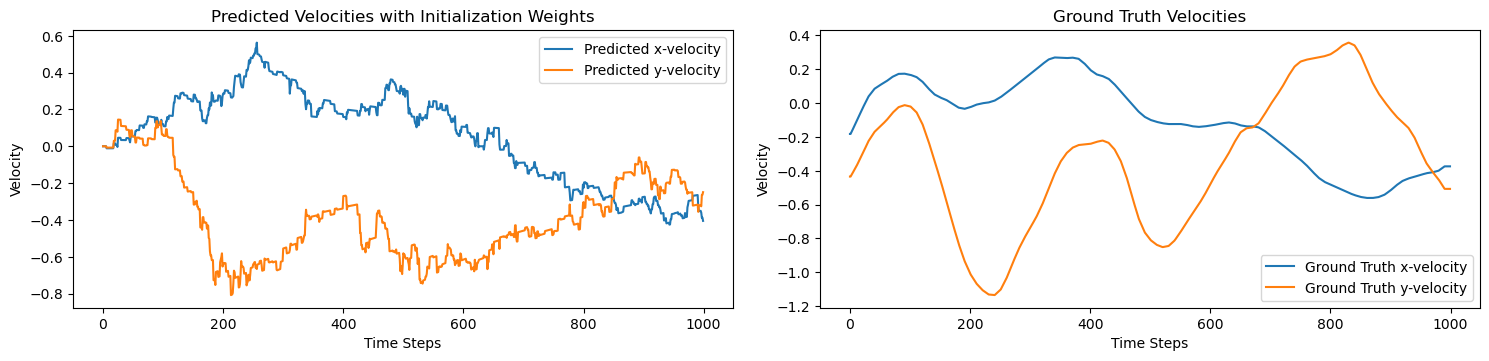


Loss Analysis:
Loss with Initialization Weights:0.621564507484436


In [85]:
def analyze_network(model, x, y):
   """
   Analyze and visualize network predictions compared to ground truth data.
   
   This function:
   1. Runs the model on sample input data
   2. Creates comparative visualizations of predictions vs ground truth
   3. Shows the model's performance with initial weights
   
   Args:
       model (nn.Module): The neural network model to analyze
       x (torch.Tensor): Input spike data of shape (batch_size, num_neurons, time_steps) 
       y (torch.Tensor): Ground truth velocities of shape (batch_size, 2, time_steps)
   
   Returns:
       torch.Tensor: Model output predictions for further analysis
   """
   # Generate predictions from the model
   output = model(x)

   # Create figure for visualization
   plt.figure(figsize=(15, 10))

   # Plot model predictions (left subplot)
   plt.subplot(3, 2, 1)
   # Extract and plot x-velocity prediction (first output channel)
   plt.plot(output[0, 0, :].detach().numpy(), label='Predicted x-velocity')
   # Extract and plot y-velocity prediction (second output channel)
   plt.plot(output[0, 1, :].detach().numpy(), label='Predicted y-velocity')
   plt.legend()
   plt.title("Predicted Velocities with Initialization Weights")
   plt.xlabel("Time Steps")
   plt.ylabel("Velocity")

   # Plot ground truth data (right subplot)
   plt.subplot(3, 2, 2)
   # Plot actual x-velocity from data
   plt.plot(y[0, 0, :].numpy(), label='Ground Truth x-velocity')
   # Plot actual y-velocity from data
   plt.plot(y[0, 1, :].numpy(), label='Ground Truth y-velocity')
   plt.legend()
   plt.title("Ground Truth Velocities")
   plt.xlabel("Time Steps")
   plt.ylabel("Velocity")

   # Adjust subplot layout to prevent overlap
   plt.tight_layout()
   plt.show()

   return output

# Initialize network testing environment
# ------------------------------------
num_neurons = 52  # Matches the dimensionality of our neural recordings

# Create test data generator
test_generator = batched_data(test_range, dt=0.001, length=1.0, batch_size=4)

# Get a batch of test data
x, y = next(test_generator)

# Run network analysis on test batch
output = analyze_network(single_layer_net, x, y)

# Evaluate network performance
# --------------------------
# Using mean squared error as our metric
criterion = nn.MSELoss()

# Generate model predictions
y_pred = single_layer_net(x) 

# Calculate model's prediction error
loss = criterion(y_pred, y) 

# Calculate baseline (null model) error
null_loss = criterion(torch.zeros_like(y), y)

print(f"\nLoss Analysis:")
print(f"Loss with Initialization Weights:{loss}")

## This takes est. 30min


Training Start:
Epoch	Train Loss	Val Loss	Learning Rate
--------------------------------------------------


  0%|          | 0/80 [00:00<?, ?it/s]

Test Loss: 0.5665
Null Loss: 0.8516
Relative Performance: 0.6652


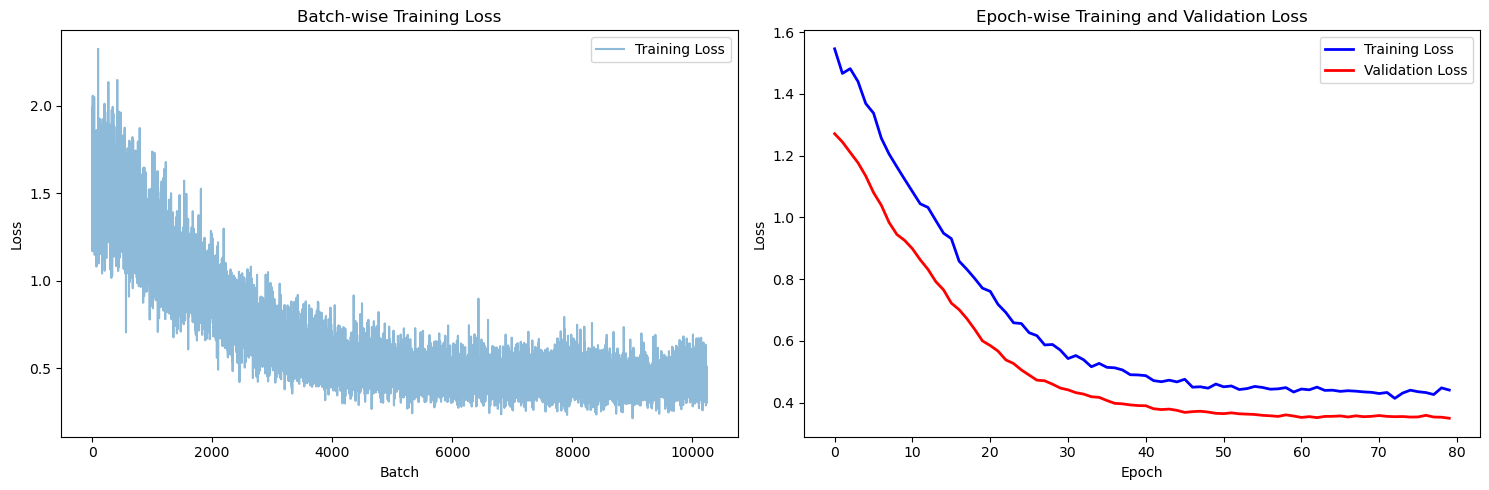

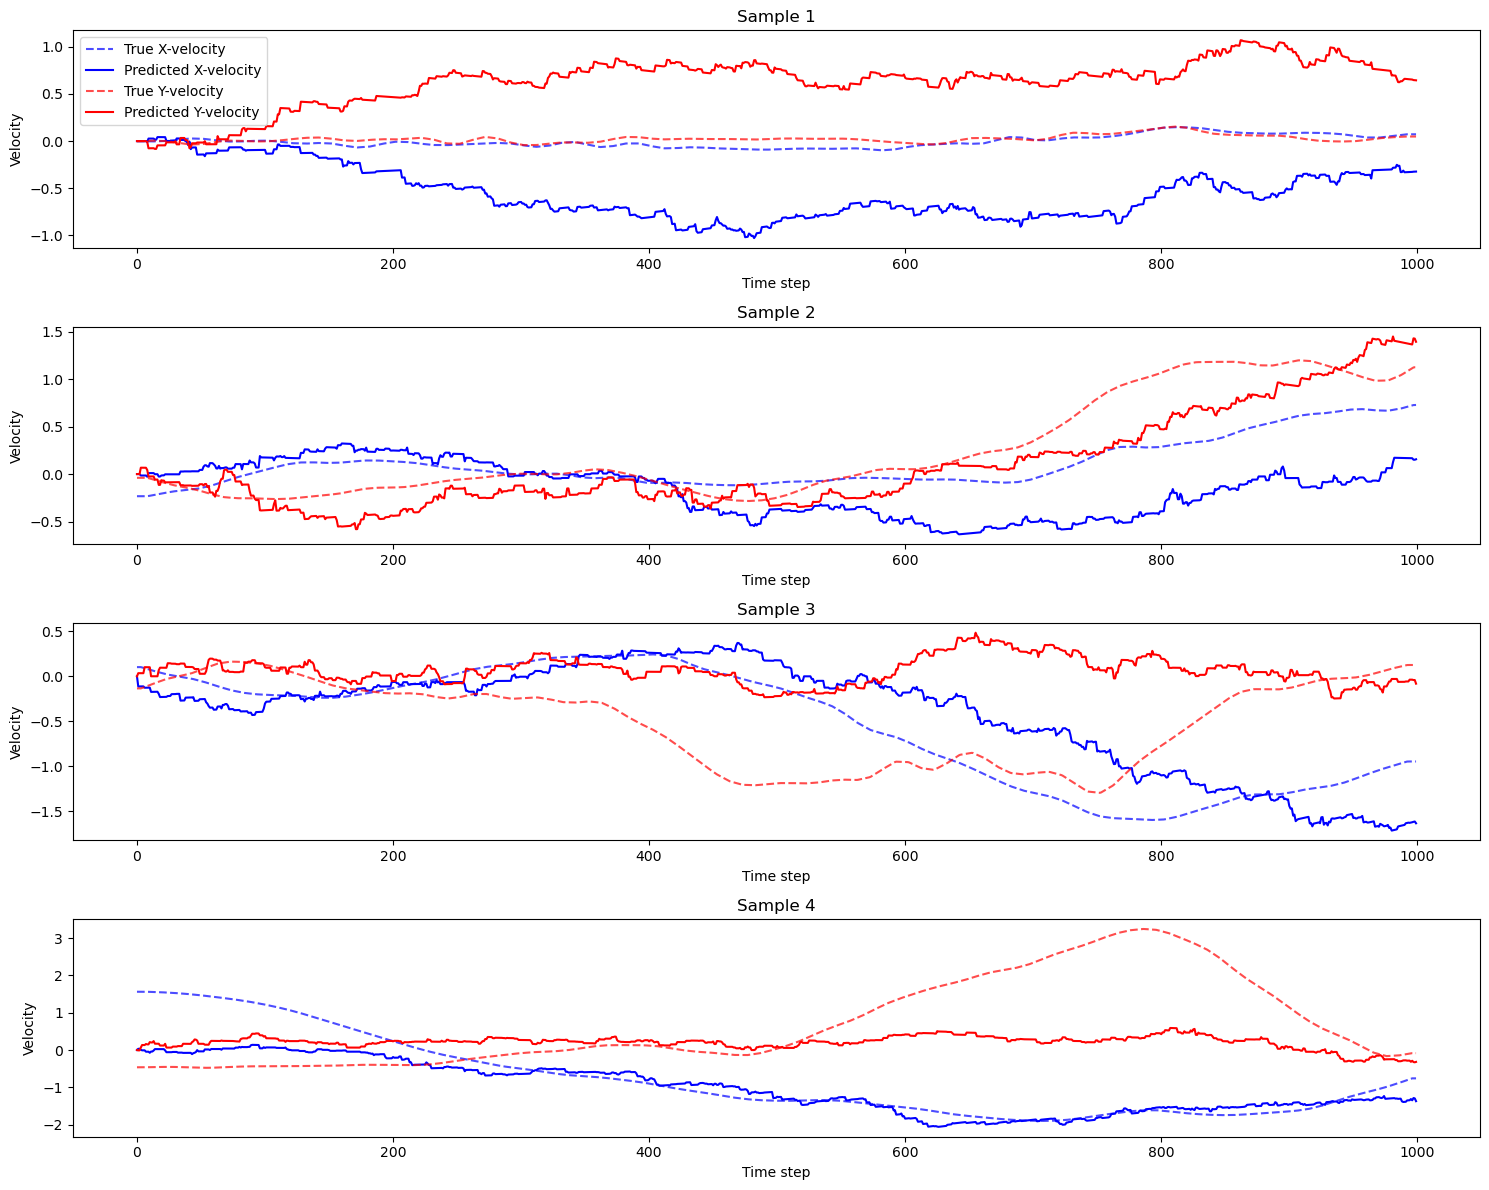

In [76]:
single_layer_net = SingleLayerSNN(num_input_neurons=52)

# Use same training parameters 
params = {
    'num_epochs': 80, 
    'learning_rate': 0.002,
    'max_batches_per_epoch': 128
}

# Train the network
history = train_network(single_layer_net, train_range, val_range, **params)

# Evaluate and visualize
test_loss, null_loss = evaluate_network(single_layer_net, test_range)
print(f"Test Loss: {test_loss:.4f}")
print(f"Null Loss: {null_loss:.4f}")
print(f"Relative Performance: {test_loss/null_loss:.4f}")

plot_training_history(history)
visualize_predictions(single_layer_net, test_range)

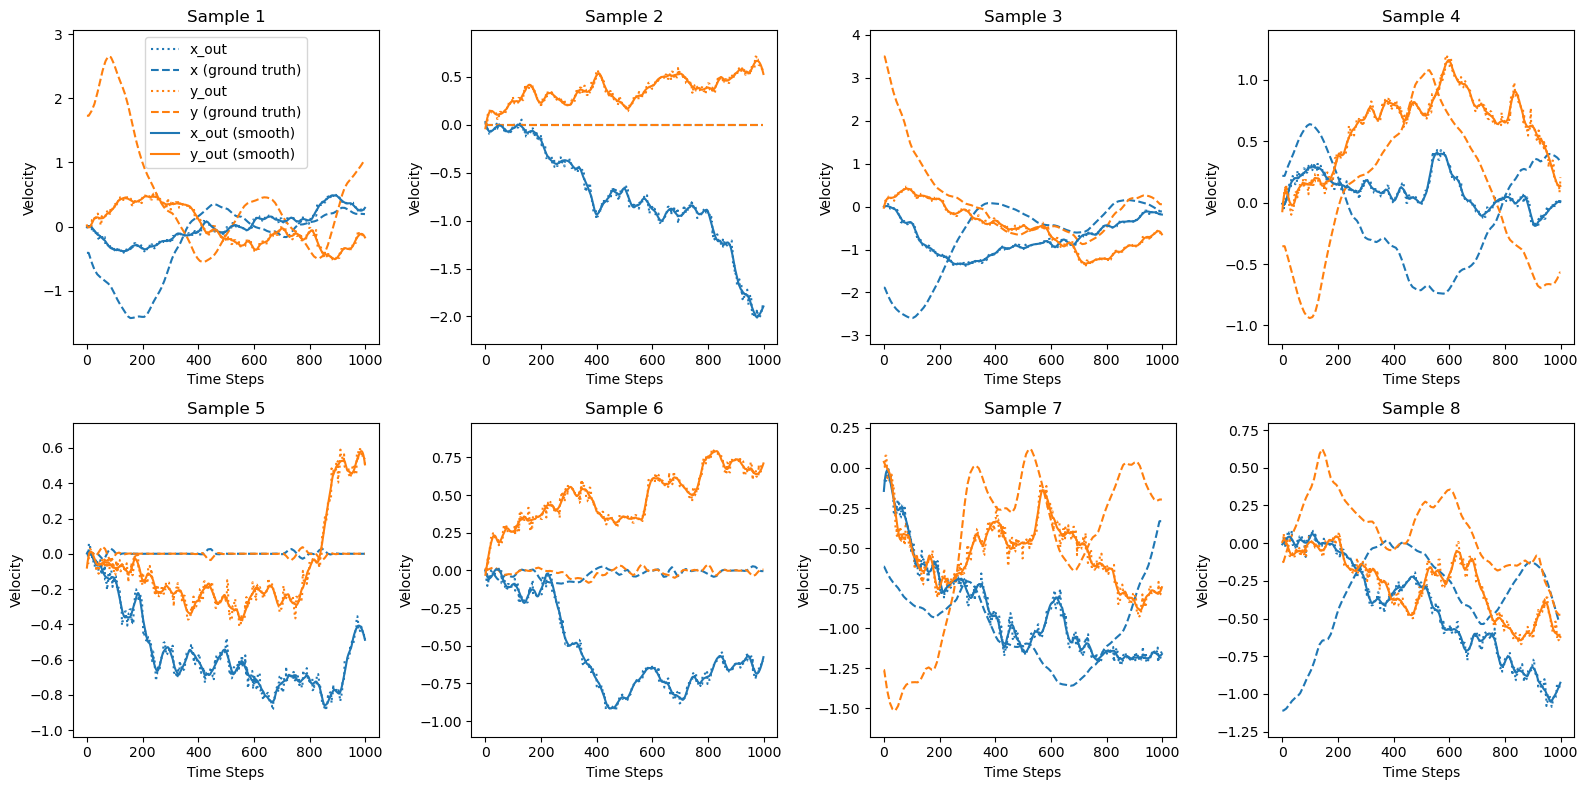

In [80]:
plt.figure(figsize=(16, 8))  
samples_plotted = 0 
num_samples_to_plot = 8  

with torch.no_grad():           
   # Generate single samples for detailed analysis
   for x, y in batched_data(test_range, dt=0.001, length=1.0, batch_size=1):
       y_out = single_layer_net(x)  # Generate predictions
       
       # Dynamic y-axis limits for better visualization
       y_min = min(torch.min(y).item(), torch.min(y_out).item())
       y_max = max(torch.max(y).item(), torch.max(y_out).item())
       y_margin = 0.1 * (y_max - y_min)  # Add 10% padding
       y_min, y_max = y_min - y_margin, y_max + y_margin

       # Create subplot for current sample
       plt.subplot(2, 4, samples_plotted + 1)

       # Plot raw predictions
       plt.plot(y_out[0, 0, :].numpy(), ':C0', label='x_out')  # x velocity
       plt.plot(y_out[0, 1, :].numpy(), ':C1', label='y_out')  # y velocity
       
       # Plot ground truth
       plt.plot(y[0, 0, :].numpy(), '--C0', label='x (ground truth)')
       plt.plot(y[0, 1, :].numpy(), '--C1', label='y (ground truth)')

       # Add smoothed predictions using Savitzky-Golay filter
       plt.plot(savgol_filter(y_out[0, 0, :].numpy(), 51, 3), '-C0', 
               label='x_out (smooth)')
       plt.plot(savgol_filter(y_out[0, 1, :].numpy(), 51, 3), '-C1', 
               label='y_out (smooth)')

       # Configure subplot aesthetics
       plt.ylim(y_min, y_max)
       plt.title(f"Sample {samples_plotted + 1}")
       plt.xlabel("Time Steps")
       plt.ylabel("Velocity")
       
       if samples_plotted == 0:  # Legend only on first subplot
           plt.legend(loc='best')

       samples_plotted += 1
       if samples_plotted >= num_samples_to_plot:
           break

plt.tight_layout()  # Prevent subplot overlap
plt.show()

## Longer Length Decoding

To improve the alignment of network outputs with the target data and extend predictions over longer time ranges, we adjusted the decoding strategy. Instead of evaluating the full output of each segment, we focused only on the final time step of each simulation segment and compared it to the corresponding target data.

A 15-second segment of testing data was selected, sampled every 0.2 seconds to yield 75 data points. For each data point, we extracted a 1-second segment of spike data immediately preceding it. These overlapping segments were processed through the simulation, and the final output of each segment was used as the network's prediction. The predicted outputs were then compared to the target data across 8 randomly chosen 15-second segments, and the results were plotted.

This approach significantly improved the network's fit to the data over extended time ranges, producing predictions that aligned more closely with the target values. This marks a successful implementation of a brain-machine interface, using the raw spiking output of neurons recorded from a monkey’s brain to predict its interactions with a computer screen.

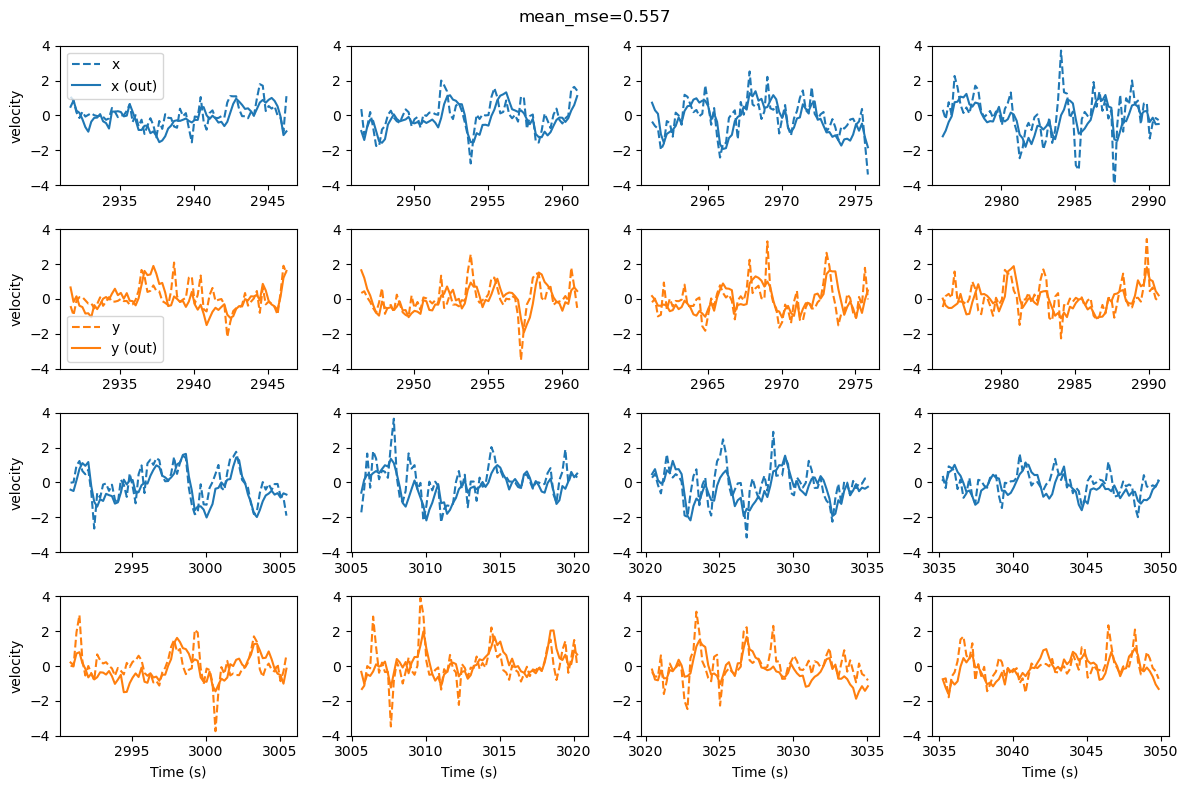

In [82]:
def decoding_plot(net, decoding_range, dt_decoding=0.2, decoding_length=15, length=1, dt=1e-3, figdims=(4, 2)):
   """
   Visualize network predictions using overlapping time segments for continuous decoding.
   
   This function:
   1. Takes 1-second windows of data, overlapping by dt_decoding
   2. Predicts velocities for each window
   3. Uses only the final prediction from each window
   4. Combines predictions into a continuous trajectory
   
   Args:
       net (nn.Module): Trained neural network model
       decoding_range (dict): Dictionary containing:
           - spike_times: List of spike times per neuron
           - vel_times: Timestamps for velocity measurements
           - vel: Velocity values (x,y coordinates)
       dt_decoding (float): Time step between predictions (default: 0.2s)
       decoding_length (float): Total time span to decode (default: 15s)
       length (float): Length of each prediction window (default: 1s)
       dt (float): Temporal resolution for network simulation (default: 1ms)
       figdims (tuple): Grid dimensions for subplot layout (default: (4,2))
   
   Displays:
       - Multiple subplots showing x and y velocity predictions
       - Ground truth vs predicted velocities
       - Mean MSE across all predictions
   """
   # Setup time windows and dimensions
   start_time = decoding_range['vel_times'][0]
   w_intervals = np.arange(start_time+length, start_time+length+decoding_length, dt_decoding)
   batch_size_single = len(w_intervals)-1
   num_time_points = int(np.round(length/dt))
   nfx, nfy = figdims
   nf = nfx*nfy
   batch_size = nf*batch_size_single
   nrows, ncols = nfy*2, nfx
   
   # Plot colors for consistency
   x_color, y_color = '#1f77b4', '#ff7f0e'  # Blue for x, Orange for y
   
   with torch.no_grad():
       # Initialize data tensors and time array
       x = torch.zeros((batch_size, len(decoding_range['spike_times']), num_time_points))
       y = torch.zeros((batch_size, 2, num_time_points))
       T = []
       
       # Process overlapping time windows
       for b in range(batch_size):
           # Define time window
           w_start = start_time + dt_decoding*b + 320
           w_end = w_start + length
           T.append(w_end)
           
           # Extract spikes for this window
           for n, spikes in enumerate(decoding_range['spike_times']):
               spikes_in_window = spikes[(spikes >= w_start) & (spikes < w_end)]
               if len(spikes_in_window):
                   spike_indices = ((spikes_in_window - w_start) / dt).astype(int)
                   x[b, n, spike_indices[spike_indices < num_time_points]] = 1
           
           # Extract and interpolate velocities
           vel_mask = (decoding_range['vel_times'] >= w_start) & (decoding_range['vel_times'] < w_end)
           vel_times = decoding_range['vel_times'][vel_mask]
           vels = decoding_range['vel'][vel_mask]
           
           if len(vel_times):
               interp_times = np.arange(w_start, w_end, dt)
               for dim in range(2):
                   y[b, dim, :] = torch.from_numpy(
                       np.interp(interp_times, vel_times, vels[:, dim])
                   )
       
       # Generate predictions and compute error
       T = np.array(T)
       y_out = net(x)
       y, y_out = y[:, :, -1], y_out[:, :, -1]  # Keep final timesteps only
       mean_mse = nn.MSELoss()(y_out, y)
       
       # Create visualization
       plt.figure(figsize=(12, 8))
       
       # Plot predictions for each segment
       for nf_i in range(nf):
           sp_x = nf_i % nfx
           sp_y = nf_i // nfx
           segment_start = batch_size_single * nf_i
           segment_end = batch_size_single * (nf_i + 1)
           
           # X velocity comparisons
           plt.subplot(nrows, ncols, sp_x+1+2*ncols*sp_y)
           plt.plot(T[segment_start:segment_end], y[segment_start:segment_end, 0].cpu(), 
                   '--', color=x_color, label='x')
           plt.plot(T[segment_start:segment_end], y_out[segment_start:segment_end, 0].cpu(), 
                   '-', color=x_color, label='x (out)')
           plt.ylim(-4, 4)
           
           # Y velocity comparisons
           plt.subplot(nrows, ncols, sp_x+1+2*ncols*sp_y+ncols)
           plt.plot(T[segment_start:segment_end], y[segment_start:segment_end, 1].cpu(), 
                   '--', color=y_color, label='y')
           plt.plot(T[segment_start:segment_end], y_out[segment_start:segment_end, 1].cpu(), 
                   '-', color=y_color, label='y (out)')
           plt.ylim(-4, 4)
           
           # Add axis labels selectively
           if sp_x == 0:
               for subplot in [sp_x+1+2*ncols*sp_y, sp_x+1+2*ncols*sp_y+ncols]:
                   plt.subplot(nrows, ncols, subplot)
                   plt.ylabel('velocity')
           
           if 2*sp_y+1 == nrows-1:
               plt.subplot(nrows, ncols, sp_x+1+2*ncols*sp_y+ncols)
               plt.xlabel('Time (s)')
           
           # Add legend to first set of plots
           if nf_i == 0:
               for subplot in [sp_x+1+2*ncols*sp_y, sp_x+1+2*ncols*sp_y+ncols]:
                   plt.subplot(nrows, ncols, subplot)
                   plt.legend(loc='best')
       
       plt.suptitle(f'mean_mse={mean_mse:.3f}')
       plt.tight_layout()
       plt.show()

decoding_plot(single_layer_net, test_range)

## Task 7: Comparing Spiking and Non-spiking

## This takes est. 1 hour


Training Start:
Epoch	Train Loss	Val Loss	Learning Rate
--------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.5829
Null Loss: 0.8977
Relative Performance: 0.6493


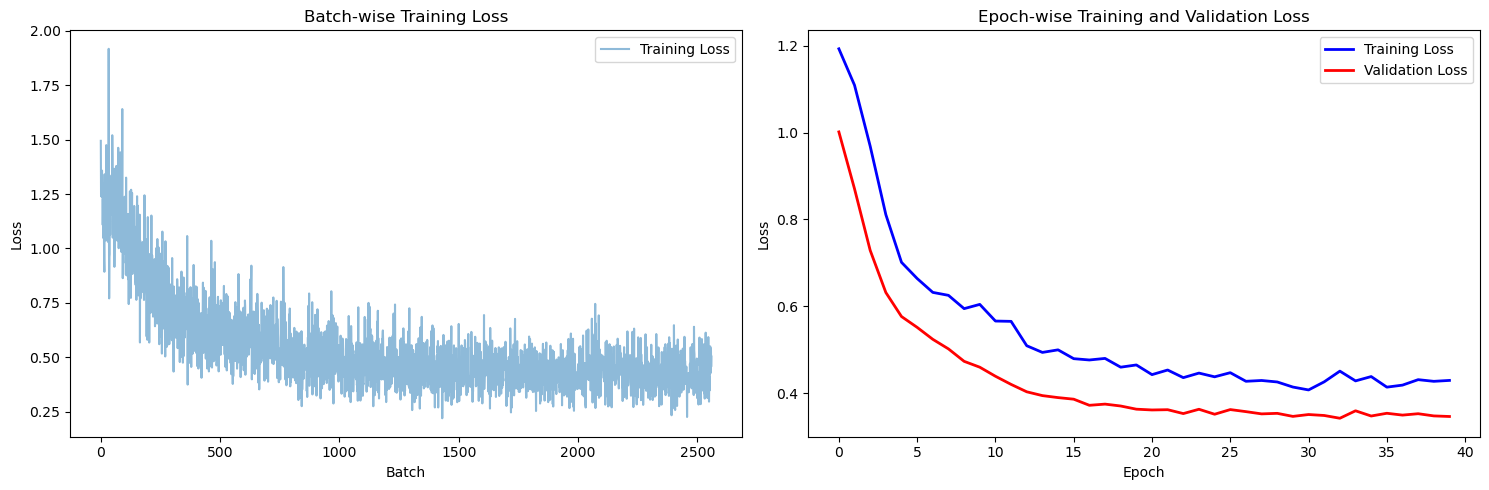

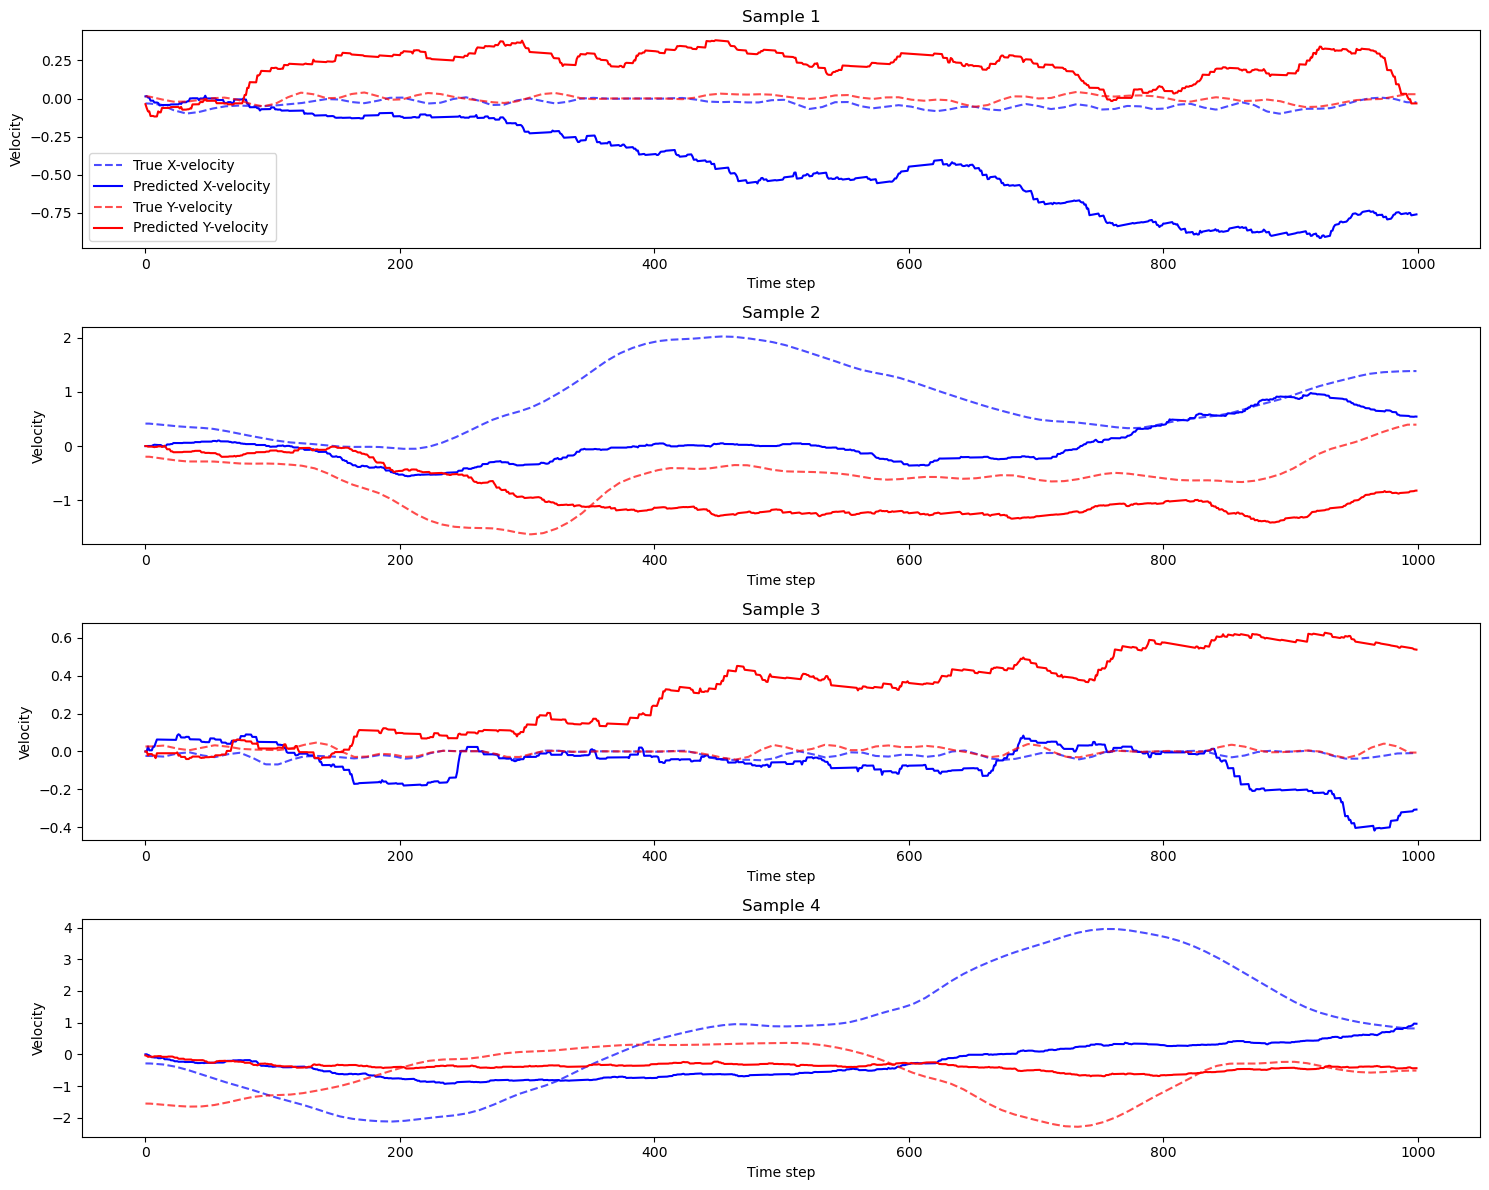

In [84]:
# Initialize network for non-spiking version
multilayer_net = MultiLayerSNN(num_input_neurons=52)

params = {
    'num_epochs': 40,
    'learning_rate': 0.002,
    'max_batches_per_epoch': 64
}

# Train
history = train_network(multilayer_net, train_range, val_range, **params)

# Evaluate and visualize
test_loss, null_loss = evaluate_network(multilayer_net, test_range)
print(f"Test Loss: {test_loss:.4f}")
print(f"Null Loss: {null_loss:.4f}")
print(f"Relative Performance: {test_loss/null_loss:.4f}")

plot_training_history(history)
visualize_predictions(multilayer_net, test_range)

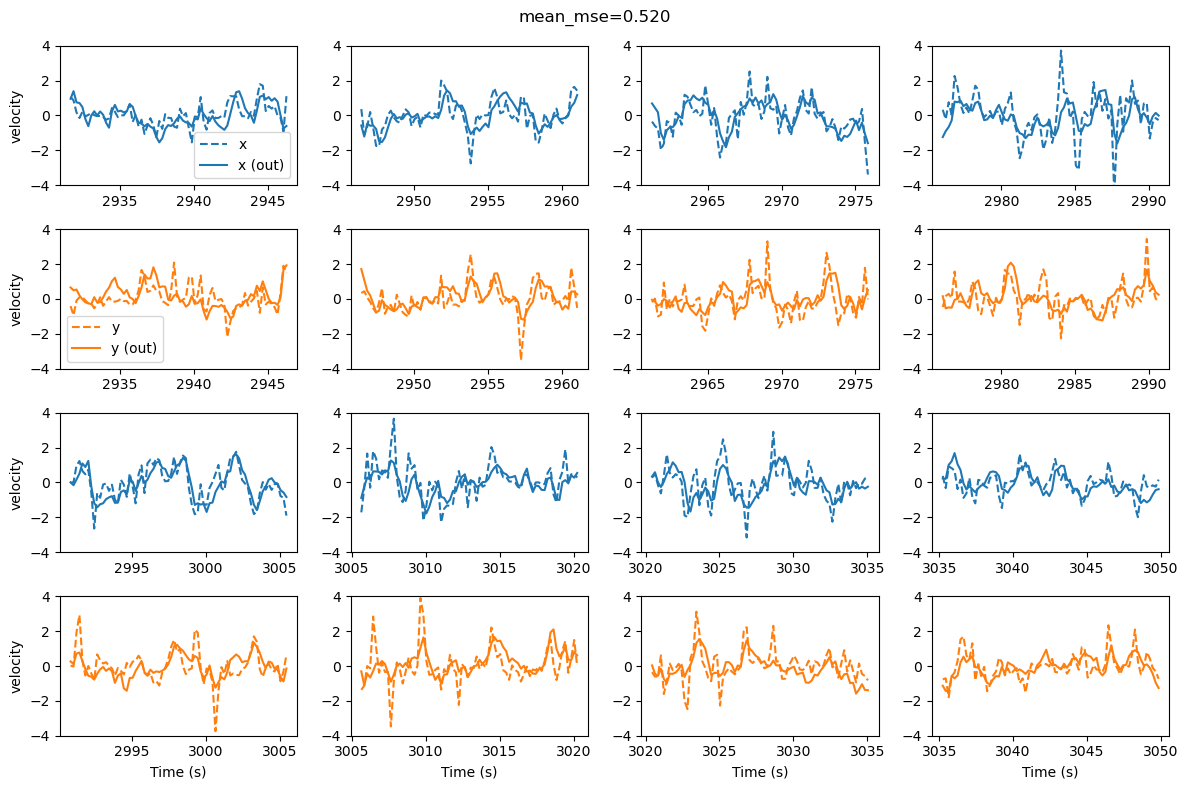

In [86]:
decoding_plot(multilayer_net, test_range)

### We conducted an experiment on the multilayer network(non-spiking) using the same parameters and training size as the single-layer training: `epoch=80`, `learning_rate=0.002`, and `max_batches_per_epoch=128`. The experiment, which took 2 hours to complete, was run in a separate file. Unfortunately, we did not have time to rerun it after cleaning up the code in a new file, so the printed output is not included here. However, the images below serve as evidence of the experiment. Notably, **we found that adding a spiking layer to the network improved performance**, with the model **achieving a mean MSE of 0.480** - **our best result across all experiments for this coursework**. Please see below for detailed results and validation confirming that it is our code.

In [ ]:
'''
Feel free to run this experiment with the code below (est. 2hrs)
'''
multilayer_net_2 = MultiLayerSNN(num_input_neurons=52)

# Training parameters 
params = {
    'num_epochs': 80,
    'learning_rate': 0.002,
    'max_batches_per_epoch': 128
}

history_2 = train_network(multilayer_net_2, train_range, val_range, **params)

test_loss, null_loss = evaluate_network(multilayer_net_2, test_range)
print(f"Test Loss: {test_loss:.4f}")
print(f"Null Loss: {null_loss:.4f}")
print(f"Relative Performance: {test_loss/null_loss:.4f}")

plot_training_history(history_2)
visualize_predictions(multilayer_net_2, test_range)

In [ ]:
decoding_plot(multilayer_net_2, test_range)

## You can view the results via think link: https://colab.research.google.com/drive/1ATfe7_4YLzy5sGTv5zai2MoOI2WJM5j4?usp=sharing

## Comparison Analysis
#### In comparing the performance of our different network architectures, we observed interesting trade-offs between complexity and accuracy. The single-layer spiking network achieved a mean MSE of 0.557, while our multilayer network with spiking hidden layer (trained for 40 epochs with 64 batches per epoch) improved performance with a mean MSE of 0.52. However, the non-spiking model, trained for 80 epochs with 128 batches per epoch, demonstrated the best performance with a mean MSE of 0.480. 

#### This suggests that, for this specific neural decoding task, non-spiking architectures may be more effective at capturing the velocity patterns. This could be due to the continuous nature of the target variables (velocities) being more naturally represented by continuous neural activations rather than discrete spikes. While the spiking networks showed reasonable performance, the additional complexity and longer training times (approximately 15x longer for the multilayer spiking network) didn't translate to better accuracy compared to the simpler non-spiking model.